# "Implémentez un modèle de scoring"
_Exploratory Data Analysis_


References used for this notebook:

- "https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda"
- 

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Mounting my Drive if on Colab

In [1]:
# from google.colab import files, output, drive
# drive.mount('/gdrive')
# %cd /gdrive

In [2]:
%pwd

'C:\\Users\\Maryse\\Google Drive\\--DATA SCIENCE\\PROJET7\\NOTEBOOKS'

Installations and importations required in the virtual environment.

In [3]:
# import os
# os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET7/NOTEBOOKS')
# # !pip install -r requirements.txt

In [4]:
from P7_functions import *

Installations (creating the requirements file)

In [81]:
# !pip install dill
# !pip install prince
# !pip install gtts
# !pip install category_encoders

In [6]:
# !pip freeze > requirements_merging.txt

Importation of modules and packages. 

In [7]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options.

In [8]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

Additional functions

In [82]:
# To play audio text-to-speech during execution

from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

## 1 Importation

In [9]:
# ### Pickling the aggregated dataset

# import dill as pickle

# with open('dict_df_agg.pkl', 'wb') as file:
#     pickle.dump(dict_df, file)

In [10]:
### Importation

import dill as pickle

with open('dict_df_agg.pkl', 'rb') as file:
    dict_df = pickle.load(file)

## 2 Exploratory analysis

### 2.0 Global shape description

#### Target identification

In [11]:
dict_df['app_train'].columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'PA_DAYS_PROLONG_PCT__max', 'PA_OUTSTANDING_LOAN__sum', 'PA_OUTSTANDING_LOAN__size',
       'PA_AMT_DIFF_PCT__mean', 'PA_AMT_DIFF_PCT__max', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC',
       'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE'],
      dtype='object', length=216)

In [12]:
# set SK_ID_CURR as the index (and thus exclude of the analysis)

dict_df['app_train'] = dict_df['app_train'].set_index('SK_ID_CURR')

In [13]:
# number of values with each outcome (0->repaid loan ; 1->not repaid loan)

dict_df['app_train']['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [14]:
# pct of values with each outcome (0->repaid loan ; 1->not repaid loan)

dict_df['app_train']['TARGET'].value_counts(normalize=True)

0   0.92
1   0.08
Name: TARGET, dtype: float64

In [15]:
# check if missing values of the target

dict_df['app_train']['TARGET'].isna().sum()

0

Name of the target feature in the dataframe : 'TARGET'

It's a binary column and it has no missing values.

The target feature has imbalanced distribution (approx 8% positive values)

#### Number of lines and columns

In [16]:
# get (nb of lines, nb of columns)

dict_df['app_train'].shape

(307511, 215)

#### Types of the features

In [17]:
# features types

dict_df['app_train'].dtypes.value_counts()

float64    173
int64       26
object      16
dtype: int64

In [18]:
# getting categorical and quantitative columns

cat_cols = dict_df['app_train'].select_dtypes(exclude=[np.number]).columns
quant_cols = dict_df['app_train'].select_dtypes(include=[np.number]).columns

bin_cols = dict_df['app_train'].columns[dict_df['app_train'].nunique()==2]
int_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['int']).columns \
                                                if c not in bin_cols]
f64_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['float64']).columns \
                                                if c not in bin_cols]
f64_low_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()<100]
f64_high_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()>=100]

low_nunique = list(f64_low_nunique) + int_cols + list(cat_cols) + list(bin_cols)

In [19]:
# categorical vs. numerical

len(cat_cols), len(quant_cols)

(16, 199)

In [20]:
# binary, integer, floats

len(bin_cols), len(int_cols), len(f64_cols)

(30, 0, 167)

In [21]:
# distinction based on number of unique values among the floats

len(f64_low_nunique), len(f64_high_nunique)

(63, 104)

In [22]:
len(low_nunique)

109

Some of the integer columns with very few unique values are already encoded categorical columns.

Some float columns also have very few unique values and could be interpreted as categorical columns.

#### Exploring missing values

<AxesSubplot:ylabel='SK_ID_CURR'>

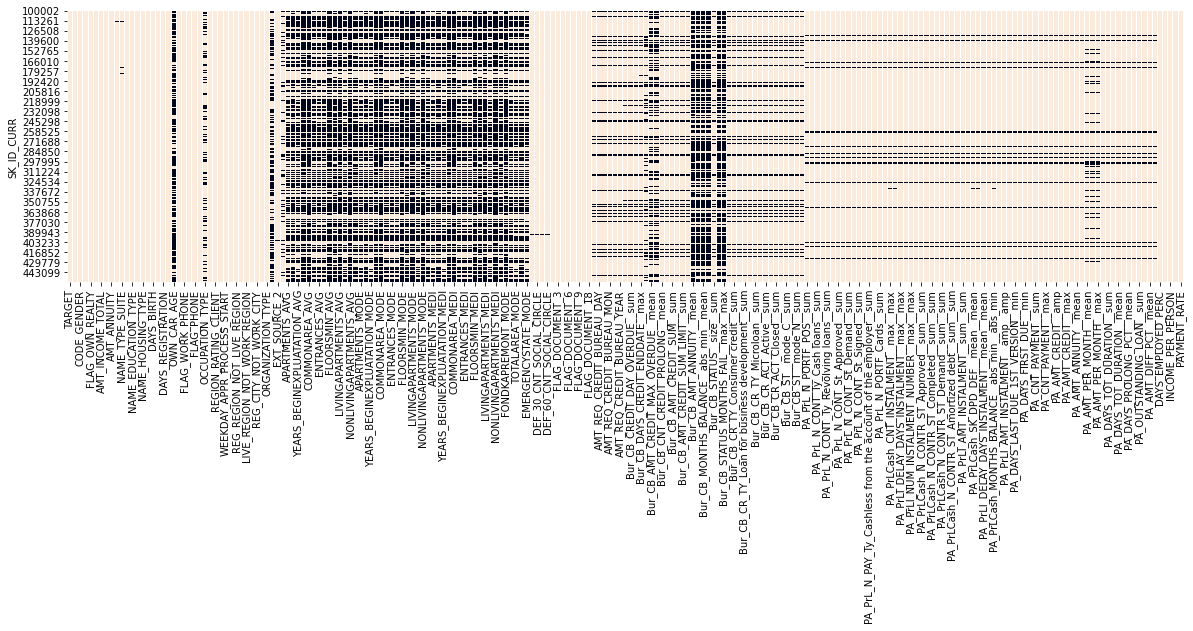

In [23]:
# global view of the missing values (black)

plt.figure(figsize=(20,5))
sns.heatmap(dict_df['app_train'].notna(), cbar=False)

In [24]:
# # fill all values coming from a sum (aggregation)

# cols_sum = dict_df['app_train'].columns[dict_df['app_train']\
#                                         .columns.str.contains('__sum')]
# dict_df['app_train'][cols_sum] = dict_df['app_train'][cols_sum].fillna(0)

In [25]:
# Have a overview of the missing values

df_miss = missing_data(dict_df['app_train'])

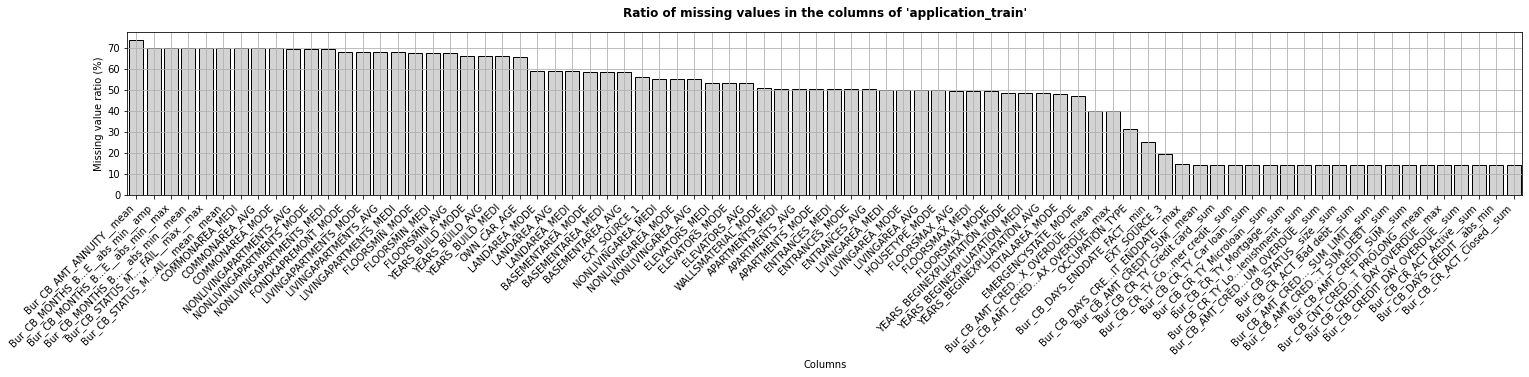

In [26]:
plot_simple_barplot(x = df_miss.index[:80],
                    y = df_miss['Percent'].iloc[:80],
                    x_lab='Columns', y_lab='Missing value ratio (%)',
                    title="Ratio of missing values in the columns of 'application_train'",
                    shorten_label=15, figsize=(25,3), color='lightgrey')

A lot of missing values.

#### Features elimination based on missing values

In [27]:
# display the number and the name of the columns to delete because exceeding 50% missing values

miss_more_45_cols = dict_df['app_train'][df_miss[df_miss['Percent']>45].index].columns
print(len(miss_more_45_cols), list(miss_more_45_cols))

55 ['Bur_CB_AMT_ANNUITY__mean', 'Bur_CB_MONTHS_BALANCE__abs_min__amp', 'Bur_CB_MONTHS_BALANCE__abs_min__max', 'Bur_CB_MONTHS_BALANCE__abs_min__mean', 'Bur_CB_STATUS_MONTHS_FAIL__max__max', 'Bur_CB_STATUS_MONTHS_FAIL__mean__mean', 'COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'OWN_CAR_AGE', 'LANDAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_

In [28]:
# keep only features with more than 50% notna values

dict_df['app_train'] = dict_df['app_train'].drop(columns=miss_more_45_cols)

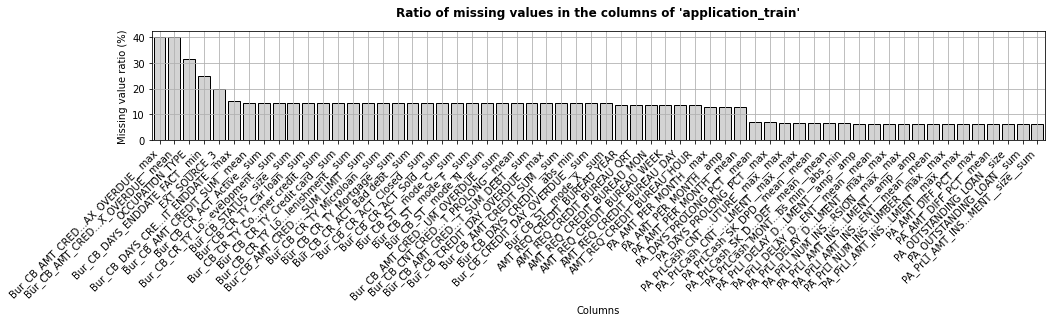

In [29]:
# 60 less filled features

ser = df_miss['Percent'][dict_df['app_train'].columns]\
                          .sort_values(ascending=False).iloc[:60]

plot_simple_barplot(x = ser.index,
                    y = ser.values,
                    x_lab='Columns', y_lab='Missing value ratio (%)',
                    title="Ratio of missing values in the columns of 'application_train'",
                    shorten_label=15, figsize=(16,2), color='lightgrey')

#### Exploring values of the remaining columns

In [30]:
# getting categorical and quantitative columns

cat_cols = dict_df['app_train'].select_dtypes(exclude=[np.number]).columns
quant_cols = dict_df['app_train'].select_dtypes(include=[np.number]).columns

bin_cols = dict_df['app_train'].columns[dict_df['app_train'].nunique()==2]
int_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['int']).columns \
                                                if c not in bin_cols]
f64_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['float64']).columns \
                                                if c not in bin_cols]
f64_low_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()<100]
f64_high_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()>=100]

low_nunique = list(f64_low_nunique) + int_cols + list(cat_cols) + list(bin_cols)

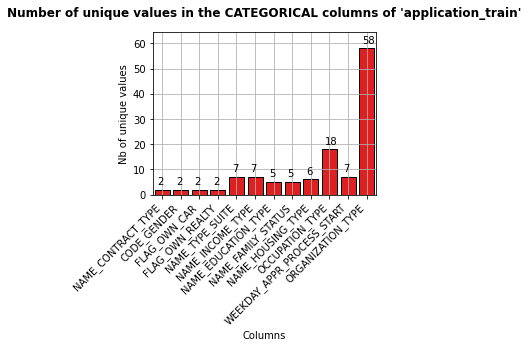

In [31]:
# number of unique values in each categorical column

if len(cat_cols) > 0:
    plot_simple_barplot(x = dict_df['app_train'][cat_cols].columns, # [:100]
                        y =  dict_df['app_train'][cat_cols].nunique(), # .iloc[:100]
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the CATEGORICAL columns of 'application_train'",
                        shorten_label=15, figsize=(4,3), color='red',
                        annotate=True)

In [32]:
# number of unique values in each integer column

if len(int_cols) > 0:
    plot_simple_barplot(x = dict_df['app_train'][int_cols].columns, # [:100]
                        y =  dict_df['app_train'][int_cols].nunique(), # .iloc[:100]
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the INTEGER columns of 'application_train'",
                        shorten_label=15, figsize=(4,3), color='darkblue',
                        annotate=True)

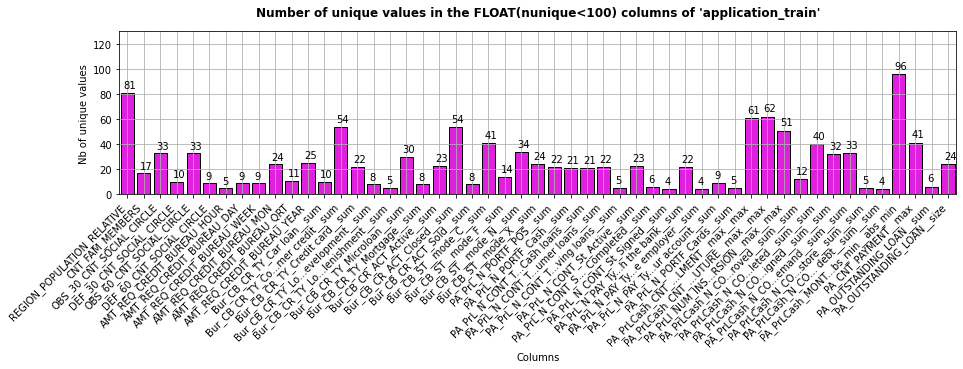

In [33]:
# number of unique values in each float column (with low nb of unique values)

if len(f64_low_nunique) > 0:
    plot_simple_barplot(x = dict_df['app_train'][f64_low_nunique].columns,
                        y =  dict_df['app_train'][f64_low_nunique].nunique(),
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the FLOAT(nunique<100) columns of 'application_train'",
                        shorten_label=15, figsize=(15,3), color='magenta',
                        annotate=True)

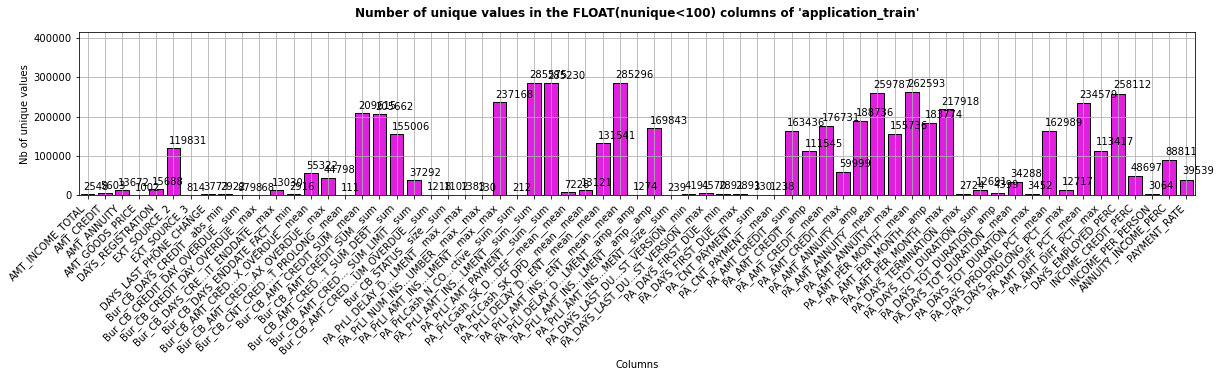

In [34]:
# number of unique values in each float column (with low nb of unique values)

if len(f64_high_nunique) > 0:
    plot_simple_barplot(x = dict_df['app_train'][f64_high_nunique].columns,
                        y =  dict_df['app_train'][f64_high_nunique].nunique(),
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the FLOAT(nunique<100) columns of 'application_train'",
                        shorten_label=15, figsize=(20,3), color='magenta',
                        annotate=True)

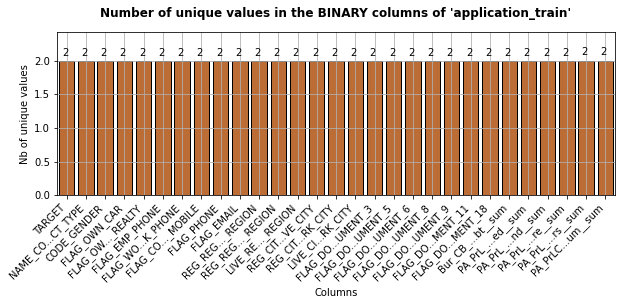

In [35]:
# number of unique values in each integer column

if len(bin_cols) > 0:
    plot_simple_barplot(x = dict_df['app_train'][bin_cols].columns, # [:100]
                        y =  dict_df['app_train'][bin_cols].nunique(), # .iloc[:100]
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the BINARY columns of 'application_train'",
                        shorten_label=7, figsize=(10,3), color='chocolate',
                        annotate=True)

In [36]:
len(dict_df['app_train'].columns)

160

### 2.1 Univariate analysis

#### Number of uniques values and unique values

In [37]:
# show the number of unique values and the first unique values

dict_df['app_train'].agg([pd.Series.nunique,
                          lambda x: ['{}'.format(s) for s in x.unique()]]).T\
                          .sort_values('nunique')

nunique  \
TARGET                                                               2   
FLAG_PHONE                                                           2   
FLAG_EMAIL                                                           2   
REG_REGION_NOT_LIVE_REGION                                           2   
REG_REGION_NOT_WORK_REGION                                           2   
LIVE_REGION_NOT_WORK_REGION                                          2   
REG_CITY_NOT_WORK_CITY                                               2   
LIVE_CITY_NOT_WORK_CITY                                              2   
PA_PrL_N_CONT_St_Returned to the store__sum                          2   
FLAG_CONT_MOBILE                                                     2   
PA_PrL_N_CONT_St_Demand__sum                                         2   
FLAG_DOCUMENT_3                                                      2   
FLAG_DOCUMENT_5                                                      2   
FLAG_DOCUMENT_6                                                      2   
FLAG_DOCUMENT_8                                                      2   
FLAG_DOCUMENT_9                                                      2   
FLAG_DOCUMENT_11                                                     2   
FLAG_DOCUMENT_18                                                     2   
Bur_CB_CR_ACT_Bad debt__sum                                          2   
PA_PrL_N_CONT_St_Approved__sum                                       2   
FLAG_WORK_PHONE                                                      2   
REG_CITY_NOT_LIVE_CITY                                               2   
NAME_CONTRACT_TYPE                                                   2   
CODE_GENDER                                                          2   
FLAG_OWN_CAR                                                         2   
FLAG_OWN_REALTY                                                      2   
PA_PrLCash_N_CONTR_ST_Canceled__sum__sum                             2   
FLAG_EMP_PHONE                                                       2   
PA_PrL_N_PORTF_Cars__sum                                             2   
REGION_RATING_CLIENT                                                 3   
REGION_RATING_CLIENT_W_CITY                                          3   
PA_PrL_N_PAY_Ty_Cashless from the account of the employer__sum       4   
PA_PrL_N_CONT_St_Signed__sum                                         4   
PA_PrLCash_N_CONTR_ST_Amortized debt__sum__sum                       4   
PA_PrL_N_PORTF_Cards__sum                                            5   
NAME_FAMILY_STATUS                                                   5   
NAME_EDUCATION_TYPE                                                  5   
Bur_CB_CR_TY_Loan for working capital replenishment__sum             5   
PA_PrLCash_N_CONTR_ST_Returned to the store__sum__sum                5   
AMT_REQ_CREDIT_BUREAU_HOUR                                           5   
PA_PrL_N_CONT_Ty_Revolving loans__sum                                5   
PA_PrL_N_CONT_St_Completed__sum                                      6   
NAME_HOUSING_TYPE                                                    6   
PA_OUTSTANDING_LOAN__sum                                             6   
NAME_INCOME_TYPE                                                     7   
NAME_TYPE_SUITE                                                      7   
WEEKDAY_APPR_PROCESS_START                                           7   
Bur_CB_CR_TY_Loan for business development__sum                      8   
Bur_CB_CR_TY_Mortgage__sum                                           8   
Bur_CB_CR_ACT_Sold__sum                                              8   
DEF_60_CNT_SOCIAL_CIRCLE                                             9   
PA_PrL_N_PAY_Ty_Non-cash from your account__sum                      9   
AMT_REQ_CREDIT_BUREAU_WEEK                                           9   
AMT_REQ_CREDIT_BUREAU_DAY                                          

#### quantitative data

In [38]:
# integers
if len(int_cols) > 0:
    plot_histograms(dict_df['app_train'], int_cols, bins=20, figsize=(18,5),
                    color='darkblue', skip_outliers=False, thresh=None, n_cols=4,
                     tight_layout={'w_pad': 0.2,
                                   'h_pad':0.65})

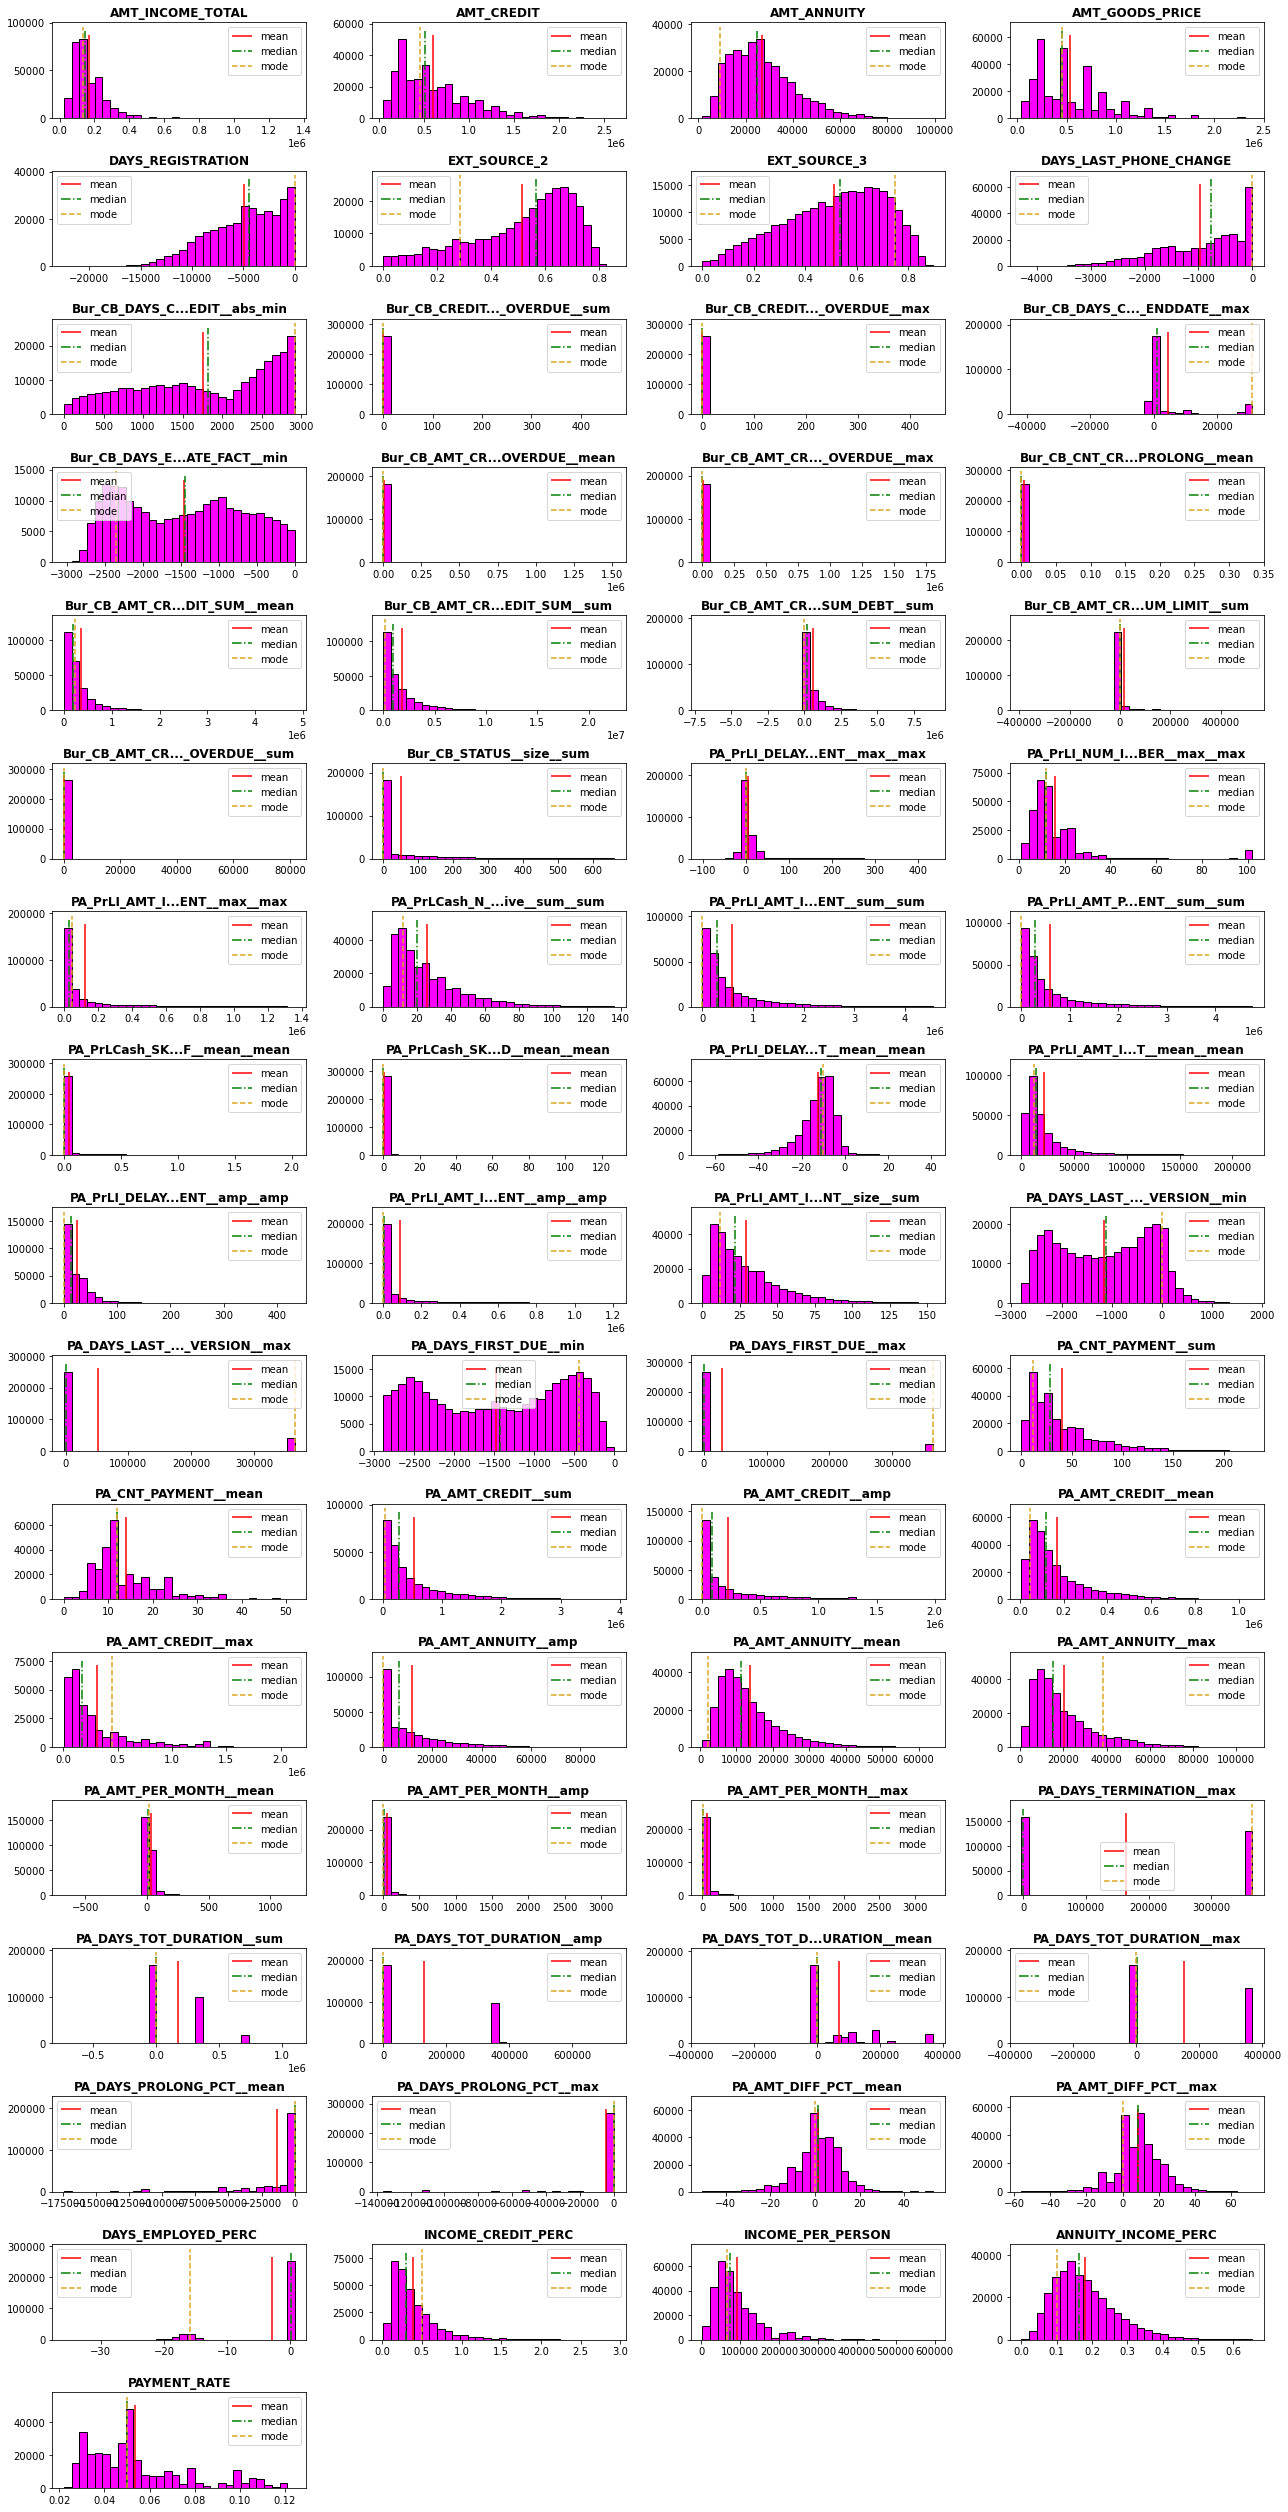

In [39]:
# floats (high nb of unique values) f64_low_nunique, f64_high_nunique

if len(f64_high_nunique) > 0:
    plot_histograms(dict_df['app_train'], f64_high_nunique, bins=30,
                    figsize=(18,35), color='magenta', skip_outliers=True,
                    thresh=5, n_cols=4, tight_layout={'w_pad': 0.2,
                                                      'h_pad':0.65})

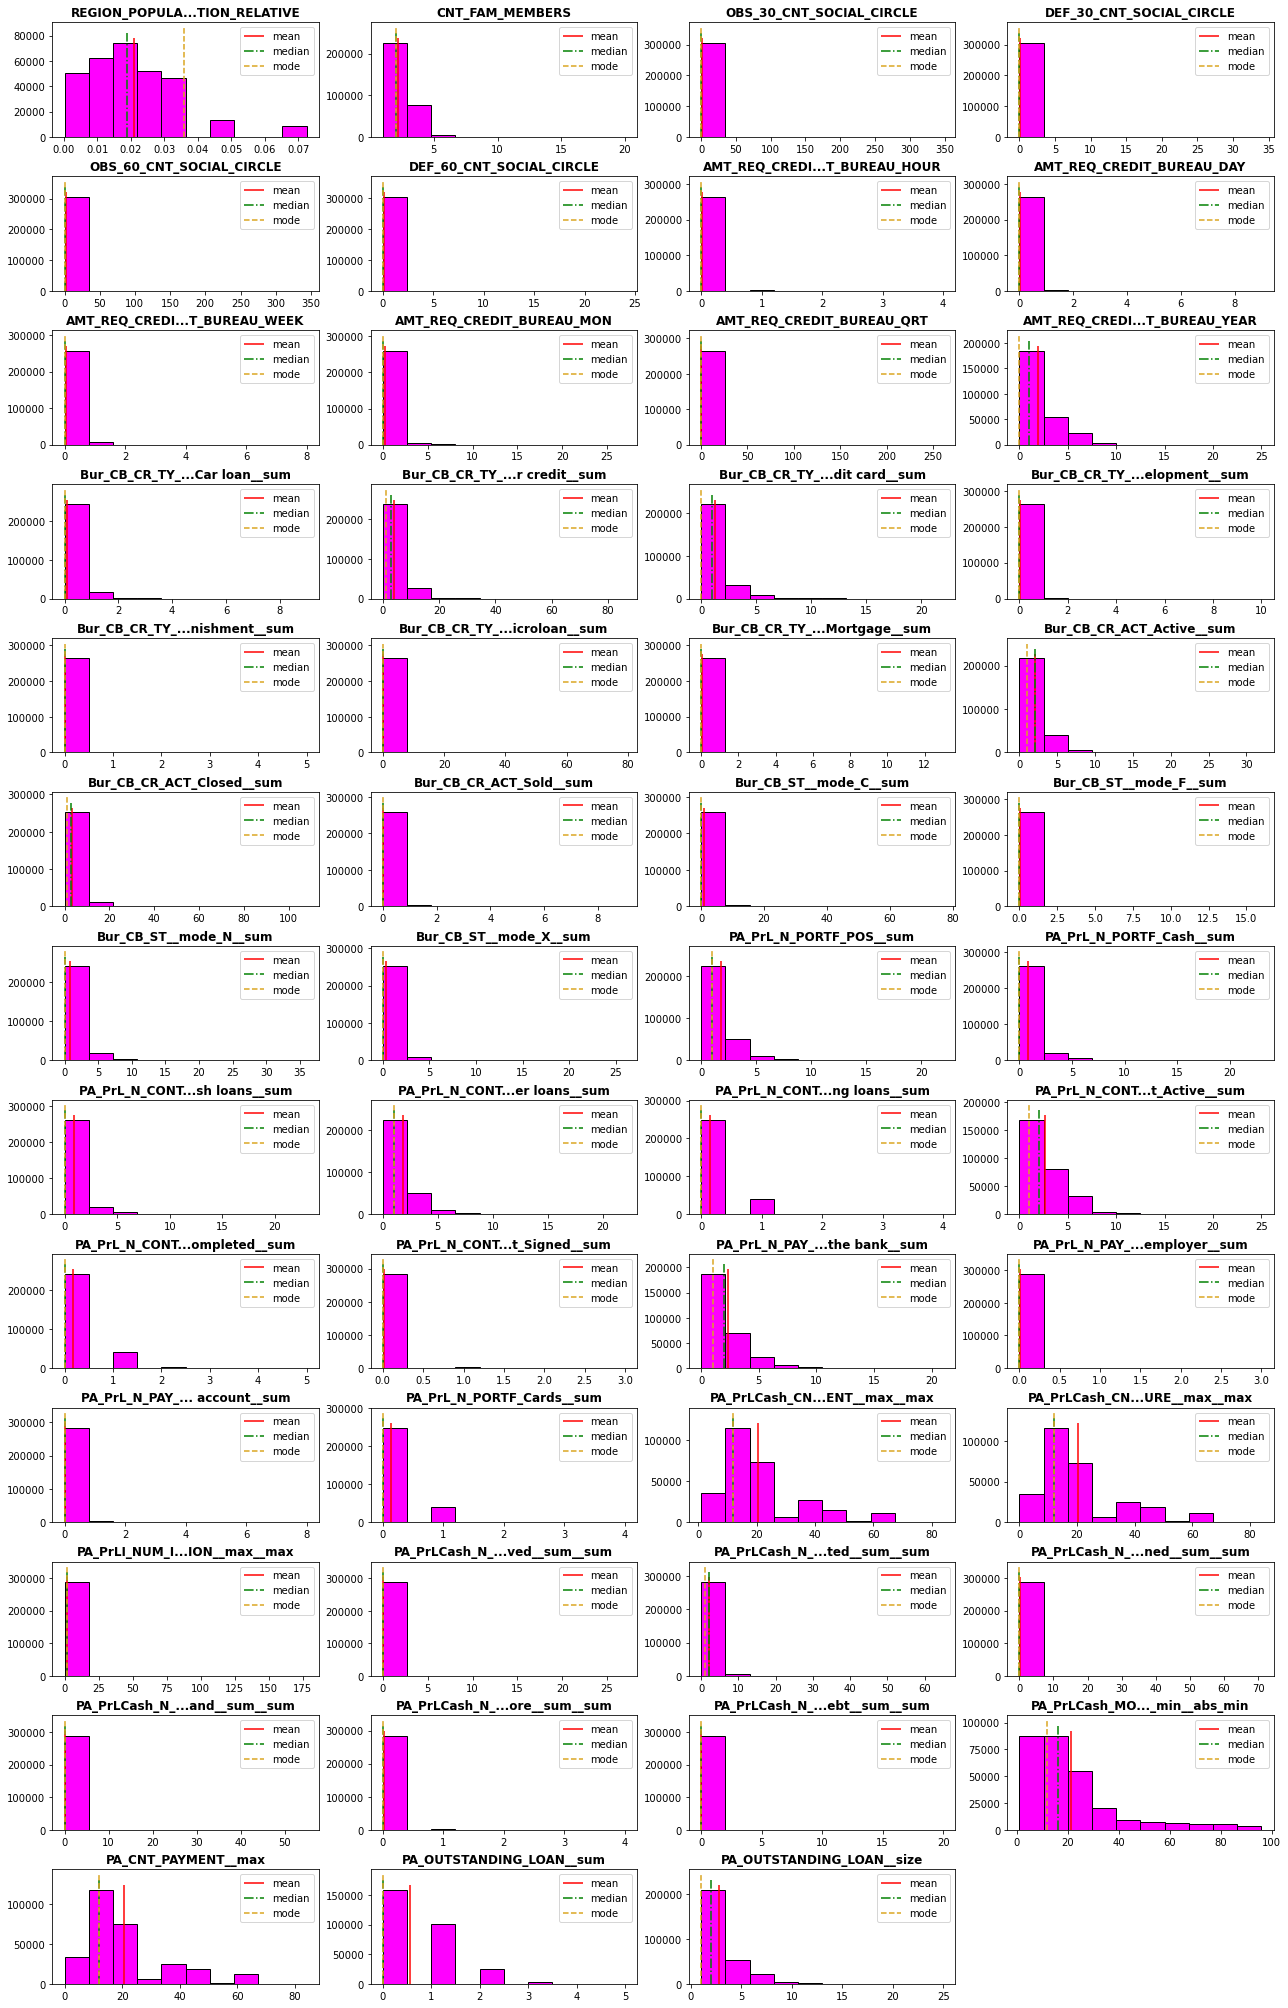

In [40]:
# floats (low nb of unique values) f64_low_nunique, f64_high_nunique

if len(f64_low_nunique) > 0:
    plot_histograms(dict_df['app_train'], f64_low_nunique, bins=10,
                        figsize=(18,28), color='magenta', skip_outliers=False,
                        thresh=5, n_cols=4, tight_layout={'w_pad': 0.2,
                                                          'h_pad':0.65})

In [41]:
cat_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

#### categorical

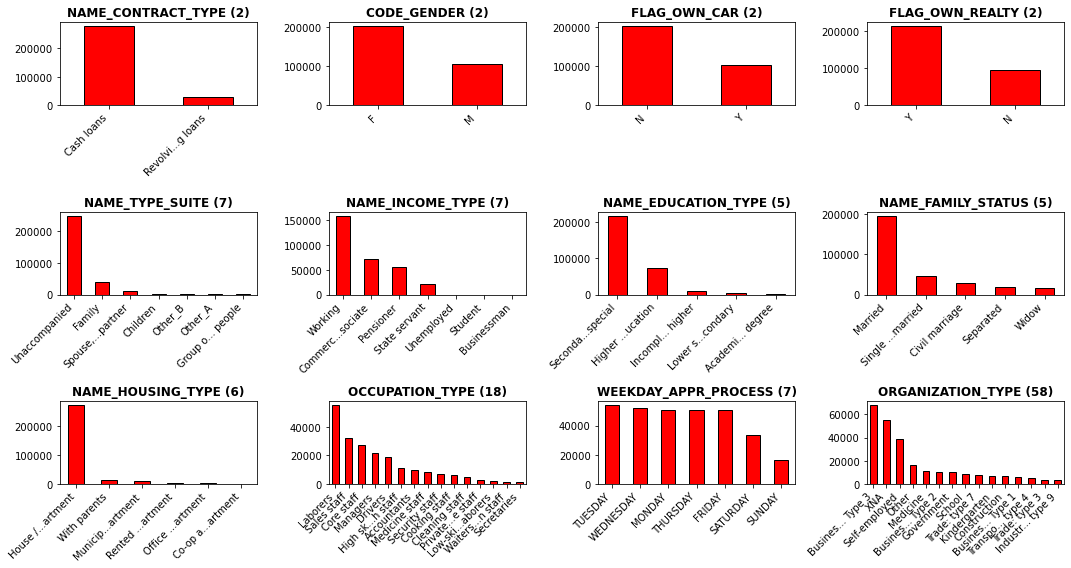

In [42]:
# explore the values of the categorical columns

plot_barplots(dict_df['app_train'], cat_cols, figsize=(15,8), n_cols=4,
              shorten_label=7, color='red')

Conclusions

- If we wish to impute, we'll need to use the median for the columns AMT_ANNUITY and AMT_GOODS_PRICE since there are a significant number of outliers in the data which would skew the mean
- For imputing null values in the categorical varaible PRODUCT_COMBINATION, we can go with the mode of the data, which is 'Cash'
CNT_PAYMENT has an even spread, and we can choose mean for imputing values in this column

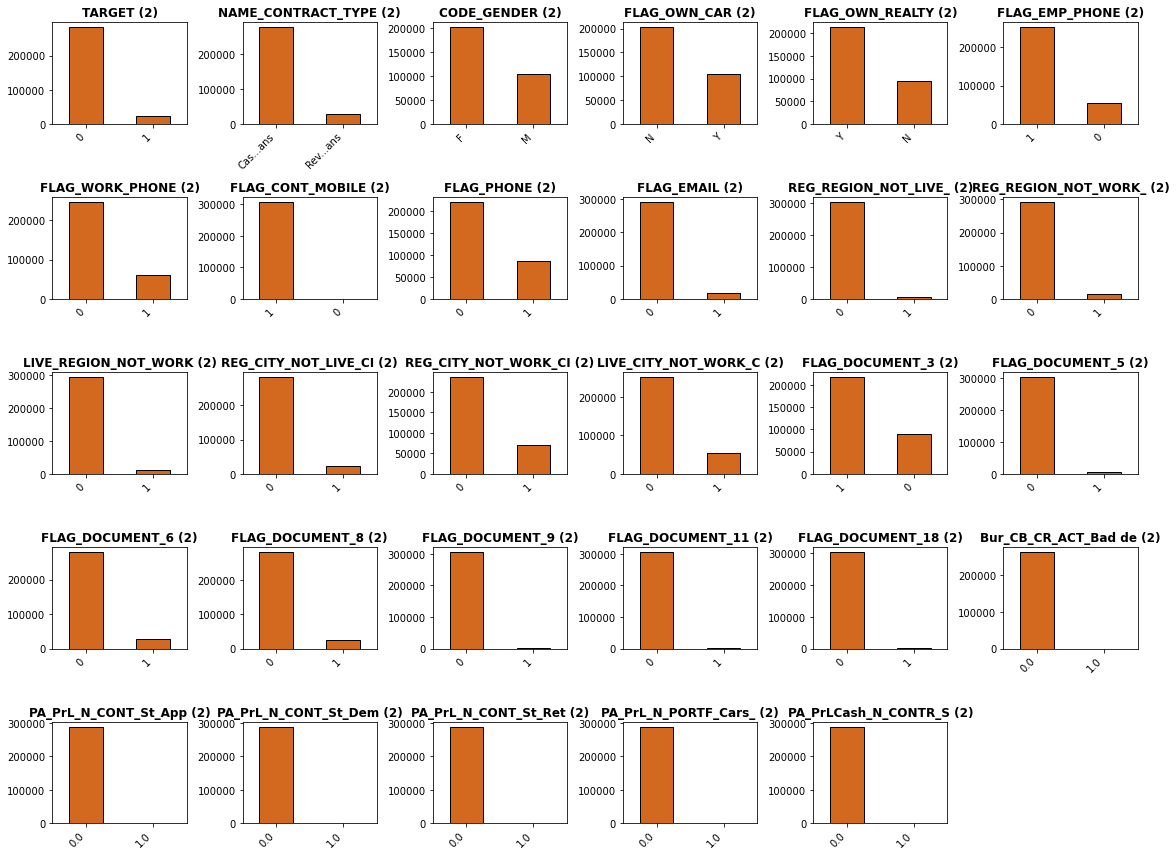

In [43]:
# explore the values of the binary columns

plot_barplots(dict_df['app_train'], bin_cols, figsize=(16,12), n_cols=6,
              shorten_label=3, color='chocolate')

Most of the quantitative features are normalized. Some are skewed or have 0 value overrepresentative.

Categorical and binary values are not balanced. May be won't contain much useful information...


<AxesSubplot:ylabel='SK_ID_CURR'>

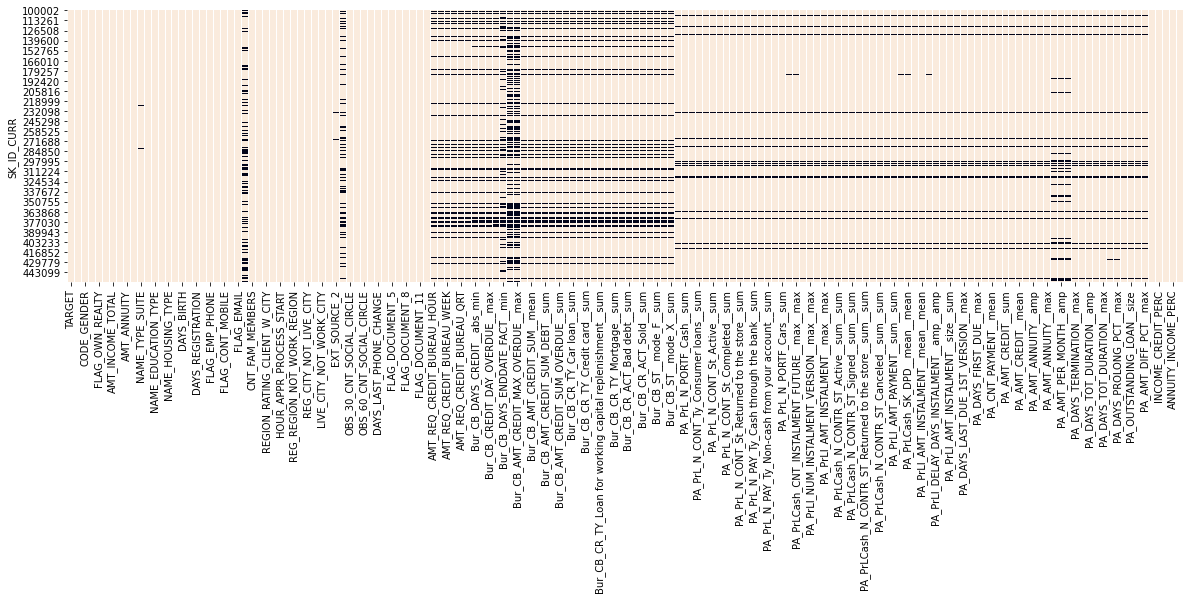

In [44]:
# global view of the missing values (black)

plt.figure(figsize=(20,5))
sns.heatmap(dict_df['app_train'].notna(), cbar=False)

In [45]:
# Have a overview of the number of missing values

df_miss = missing_data(dict_df['app_train'])

In [46]:
### create subdataframes

# Miscellaneous
cols = df_miss[(df_miss['Percent']<6)].index
df_1 = dict_df['app_train'][cols]
# display(df_1.select_dtypes().value_counts().to_frame())

# previous applications (Home Credit)
cols = df_miss[(df_miss['Percent']>6) & (df_miss['Percent']<13)].index
df_2 = dict_df['app_train'][cols]

# Previous requests to bureau
cols = df_miss[(df_miss['Percent']>13) & (df_miss['Percent']<14)].index
df_3 = dict_df['app_train'][cols]

# previous applications (Credit Bureau)
cols = df_miss[df_miss['Percent']>14].index
df_4 = dict_df['app_train'][cols]

### 2.2 Bivariate analysis

In [47]:
dict_df['app_train']['DAYS_EMPLOYED'] = \
    dict_df['app_train']['DAYS_EMPLOYED'].replace({365243: np.nan})

In [48]:
dict_df['app_train']['PA_DAYS_FIRST_DUE__max'] = \
    dict_df['app_train']['PA_DAYS_FIRST_DUE__max'].replace({365243: np.nan})

In [49]:
dict_df['app_train']['PA_DAYS_LAST_DUE_1ST_VERSION__max'] = \
    dict_df['app_train']['PA_DAYS_LAST_DUE_1ST_VERSION__max'].replace({365243: np.nan})

In [50]:
dict_df['app_train']['PA_DAYS_TERMINATION__max'] = \
    dict_df['app_train']['PA_DAYS_TERMINATION__max'].replace({365243: np.nan})

#### Target - features relationships

In [51]:
target_1_df = dict_df['app_train'][dict_df['app_train']['TARGET']==1]
target_0_df = dict_df['app_train'][dict_df['app_train']['TARGET']==0]

In [52]:
# cat_cols, quant_cols, bin_cols, int_cols, f64_cols, 
# f64_low_nunique, f64_high_nunique

In [53]:
print(f"There is {len(f64_cols + int_cols)} numerical, non binary columns")
print(f"There is {len(bin_cols)} binary columns")
print(f"There is {len(cat_cols)} categorical columns")

There is 116 numerical, non binary columns
There is 29 binary columns
There is 12 categorical columns


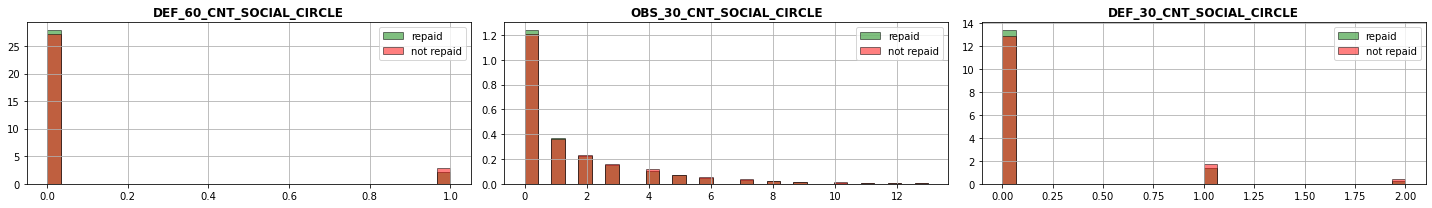

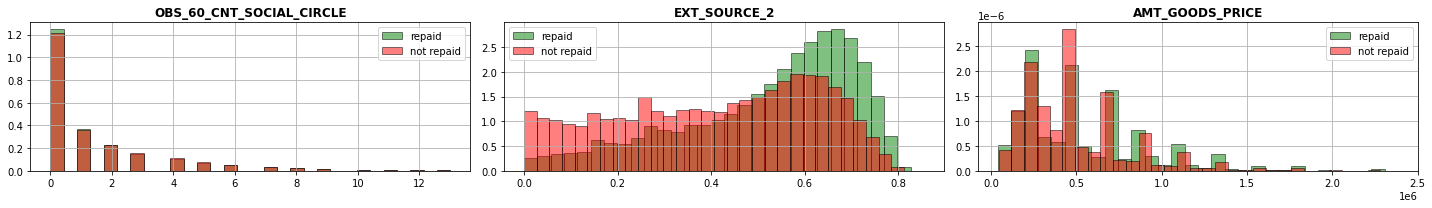

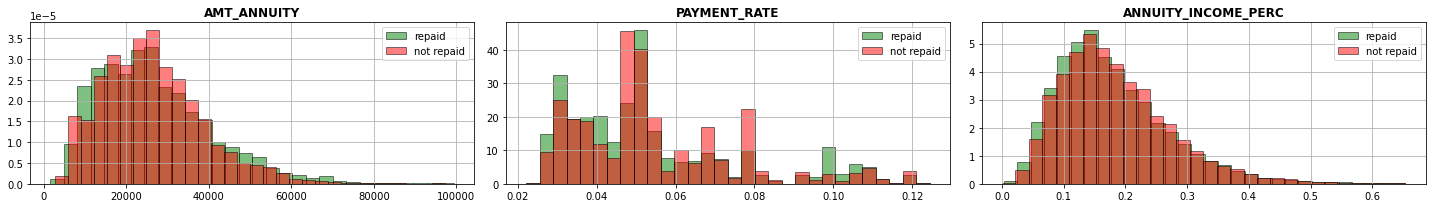

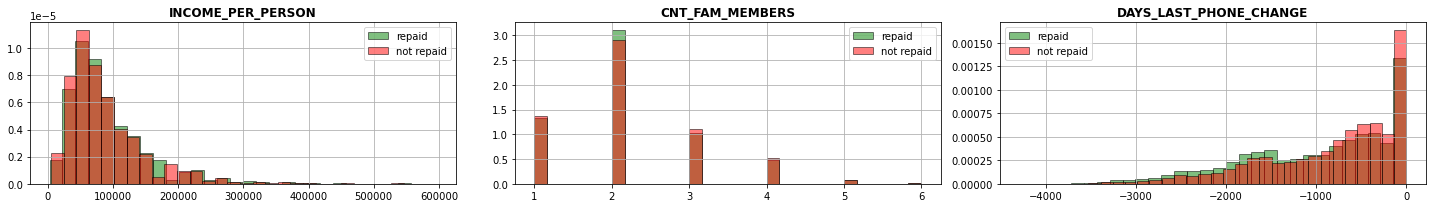

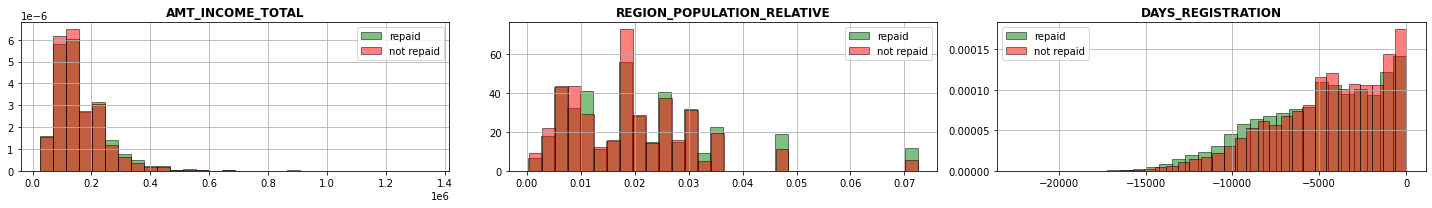

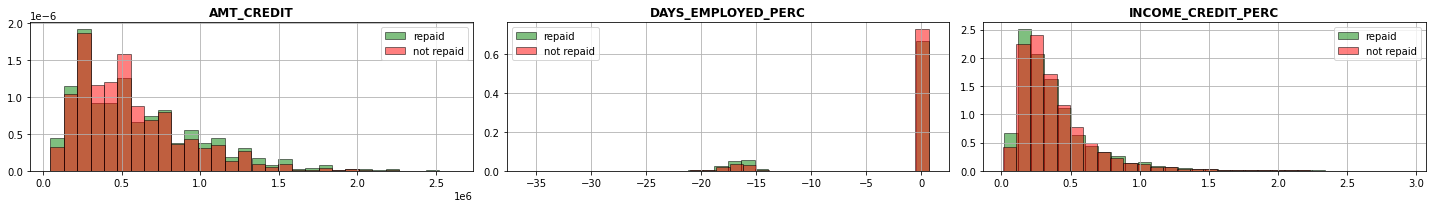

In [54]:
# All quantitative columns in Miscellaneous (df_1)

cols =  [col for col in df_1.columns if col in (f64_cols + int_cols)]

plot_cat_histograms(df=dict_df['app_train'],
                    ind_tuple=(target_0_df.index, target_1_df.index),
                    cols=cols, labels = ('repaid', 'not repaid'),
                    colors = ('green', 'red'),
                    bins=30, figwidth=20, n_cols=3, tight_layout=True, 
                    skip_outliers=True, thresh=5, sh_tit=20)

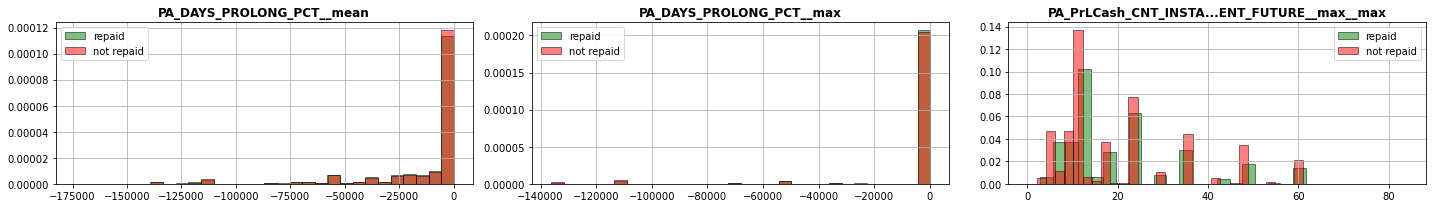

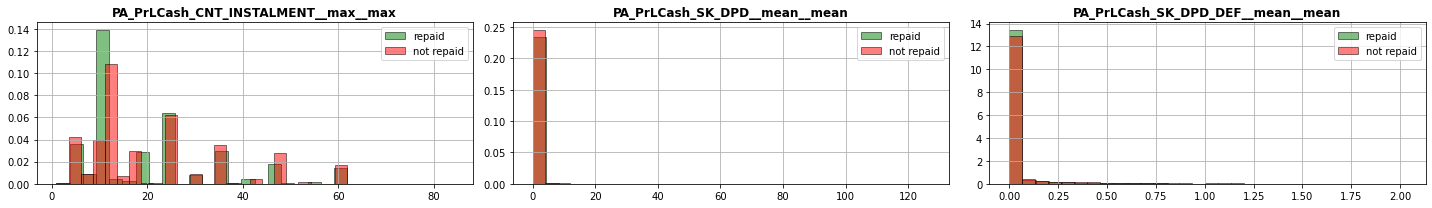

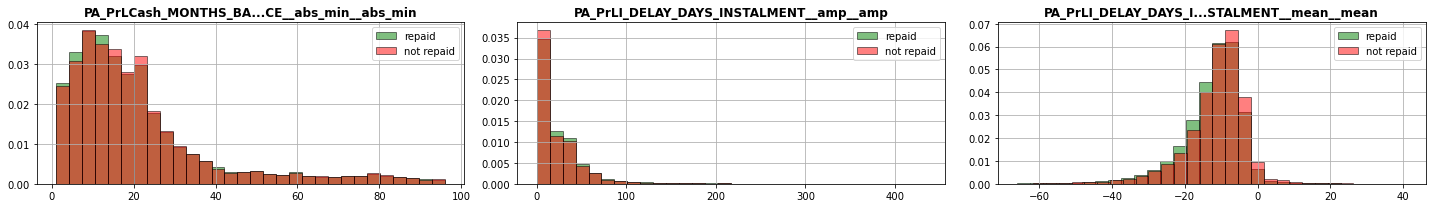

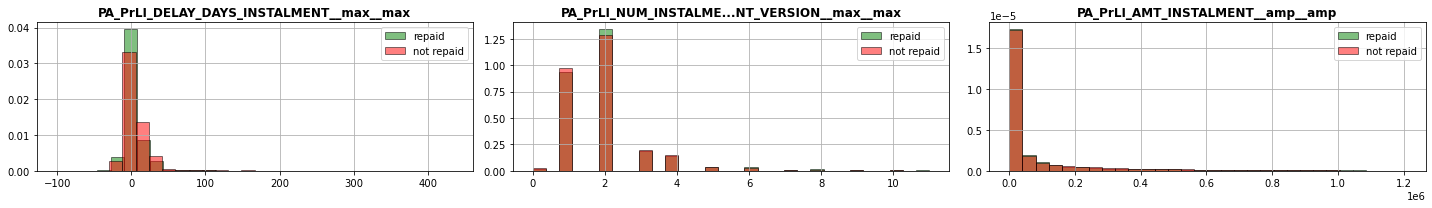

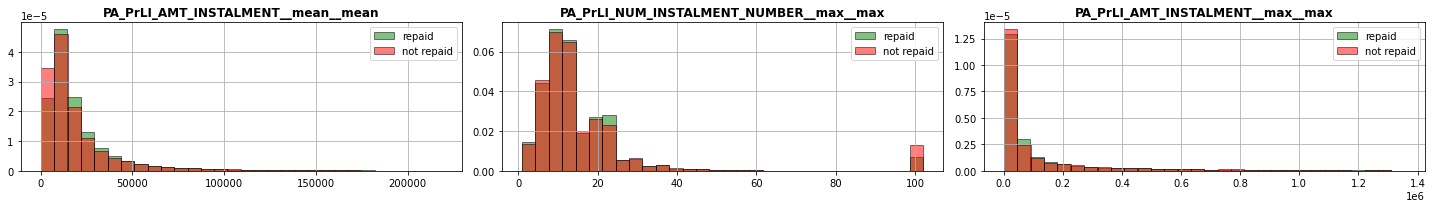

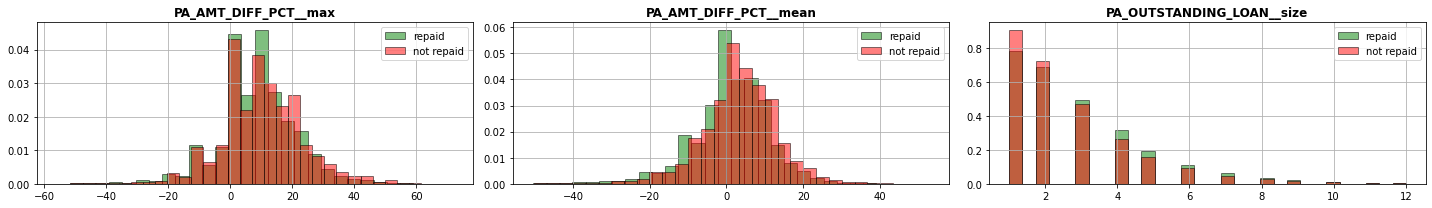

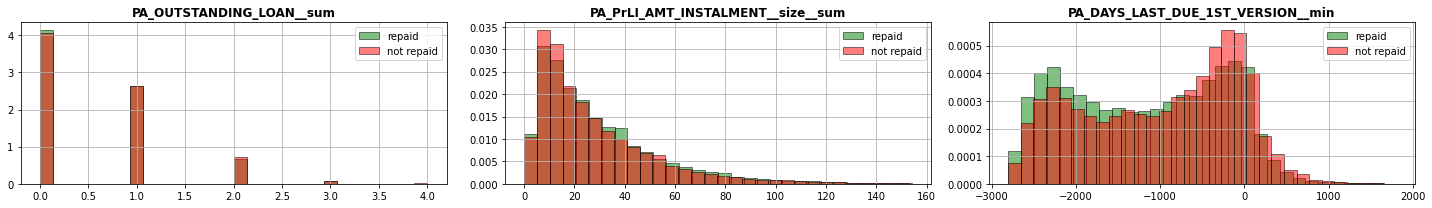

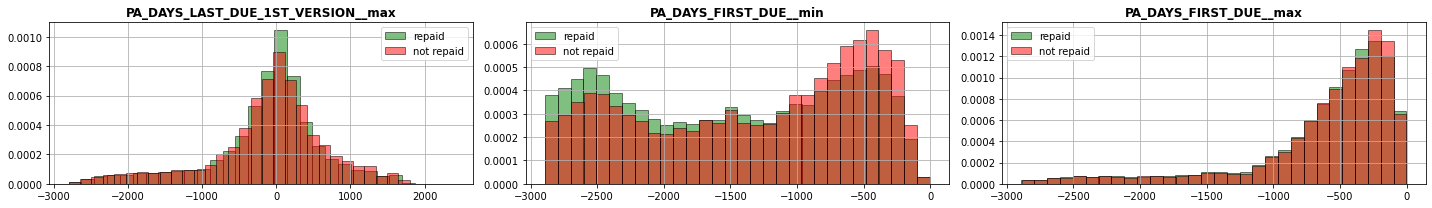

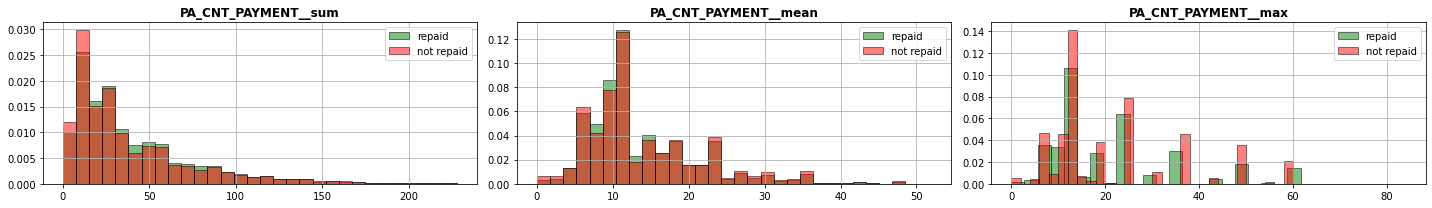

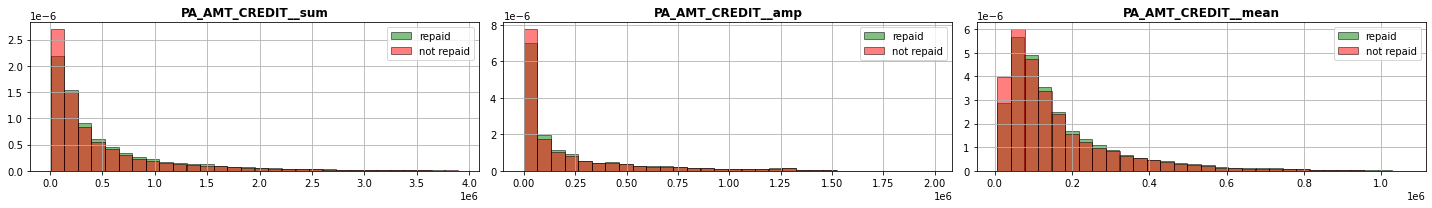

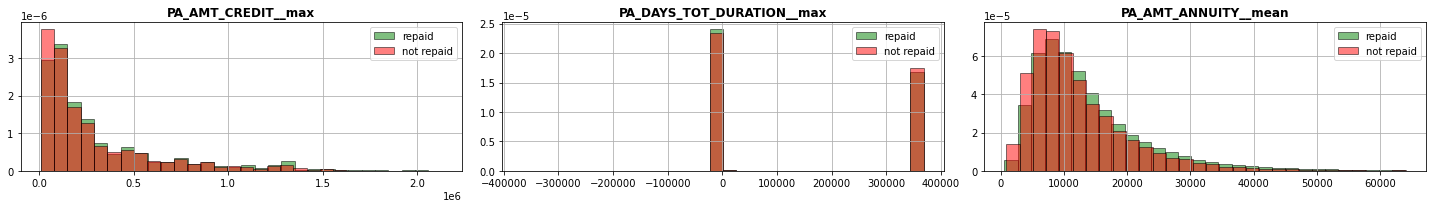

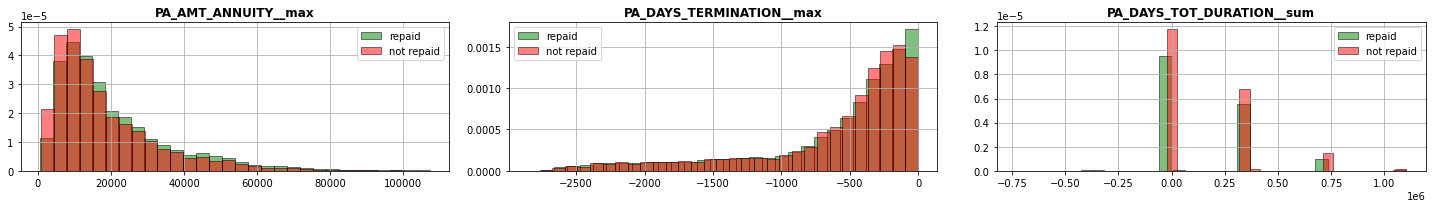

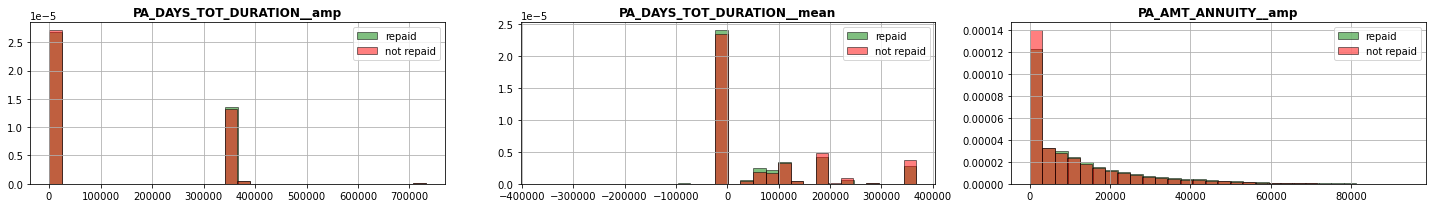

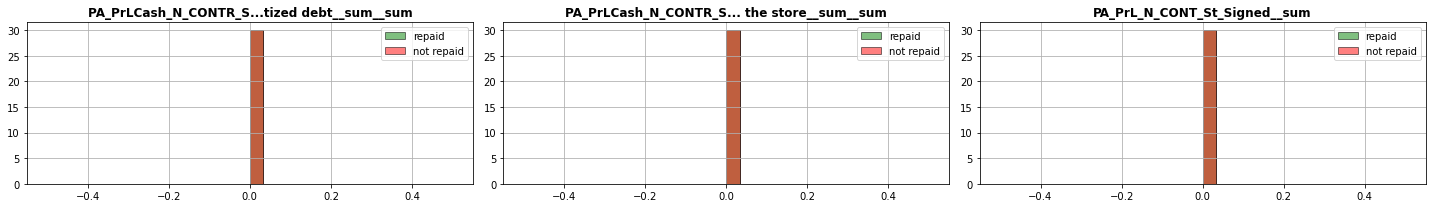

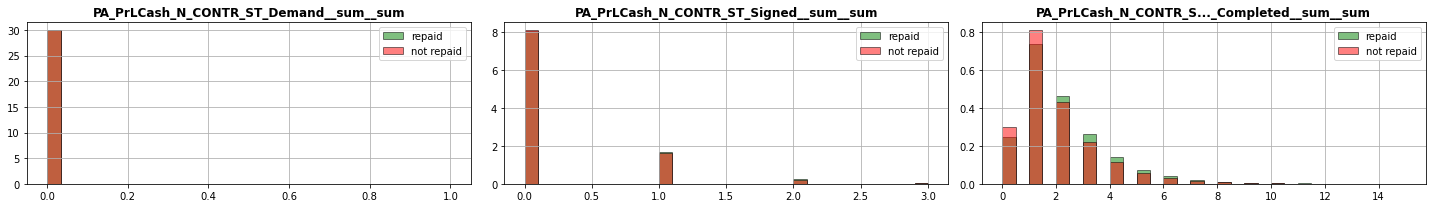

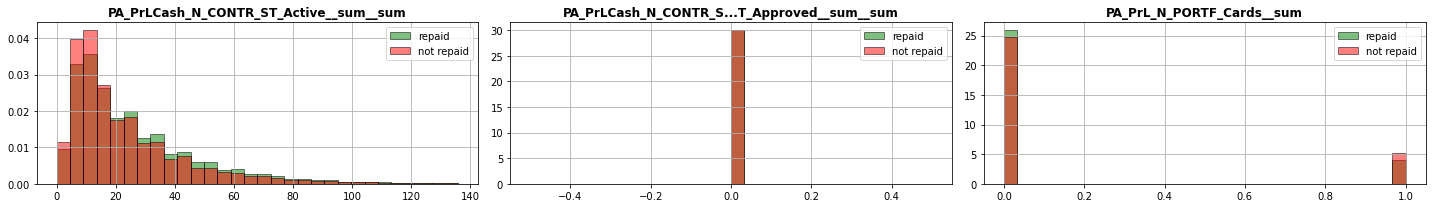

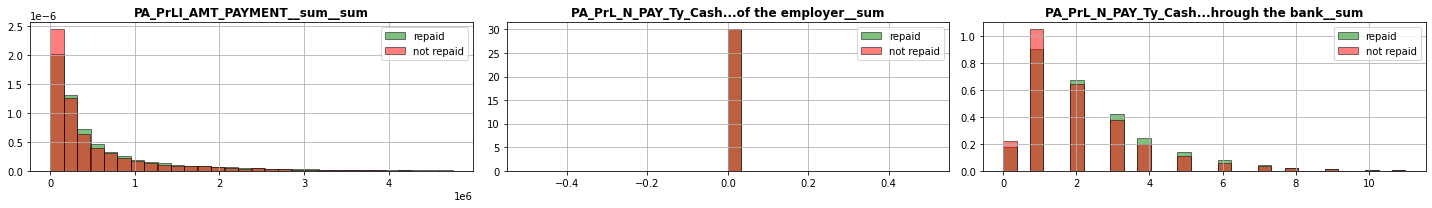

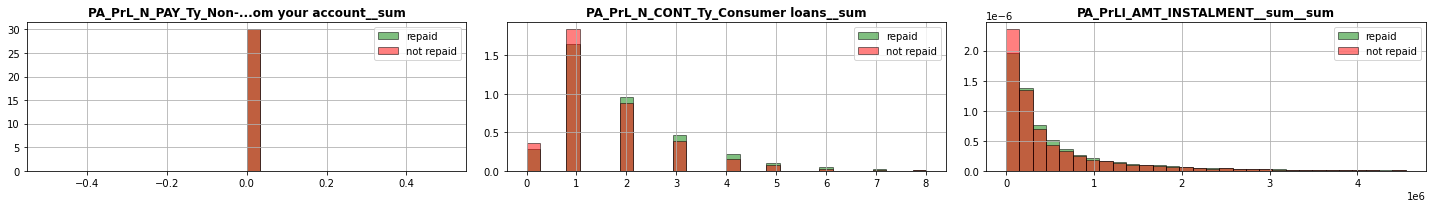

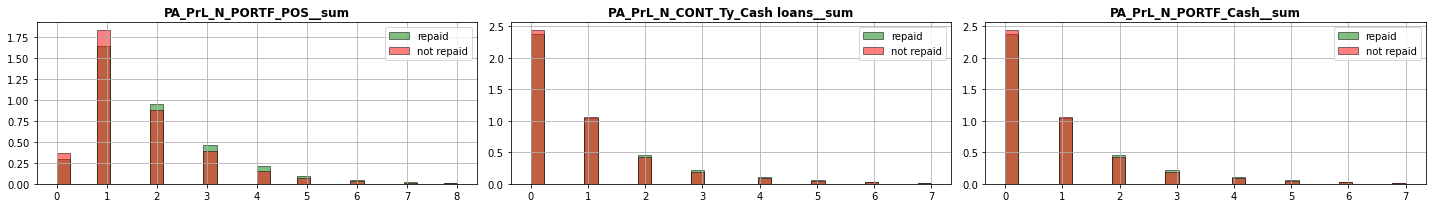

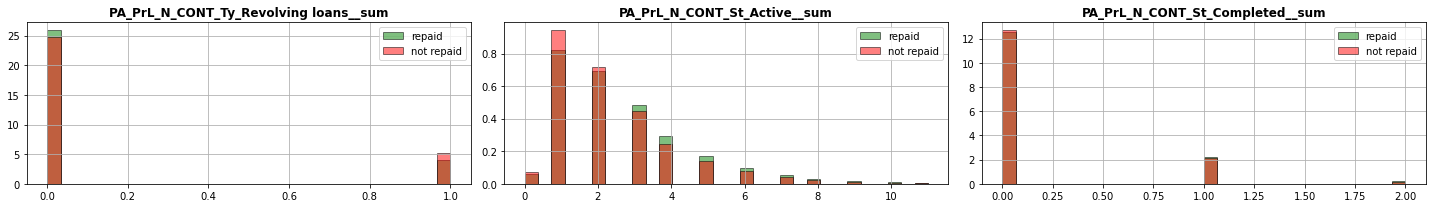

In [55]:
# All quantitative columns in previous applications (Home Credit) (df_2)

cols =  [col for col in df_2.columns if col in (f64_cols + int_cols)]

plot_cat_histograms(df=dict_df['app_train'],
                    ind_tuple=(target_0_df.index, target_1_df.index),
                    cols=cols, labels = ('repaid', 'not repaid'),
                    colors = ('green', 'red'),
                    bins=30, figwidth=20, n_cols=3, tight_layout=True, 
                    skip_outliers=True, thresh=5, sh_tit=20) 

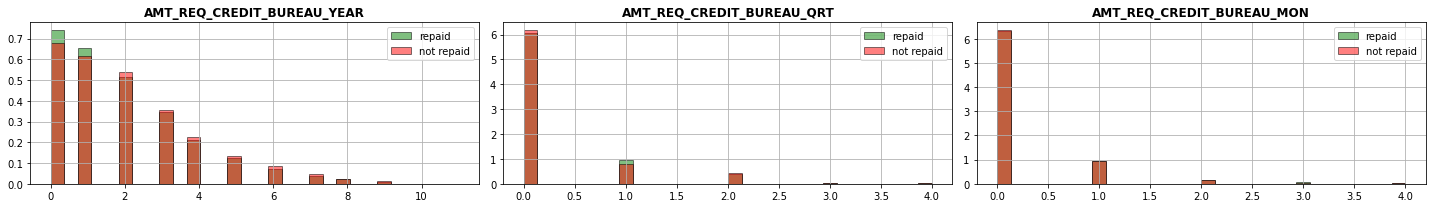

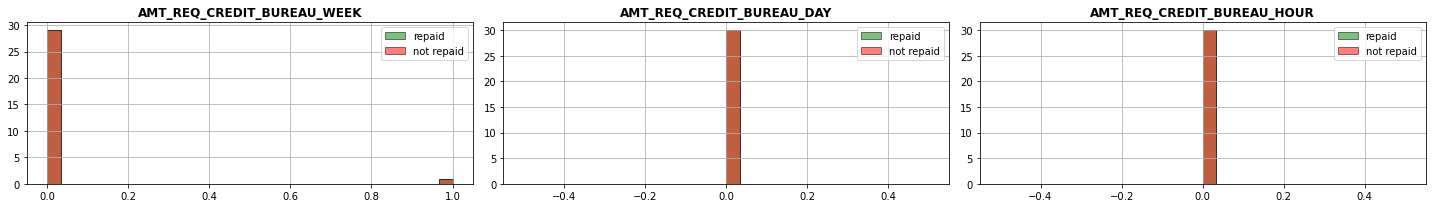

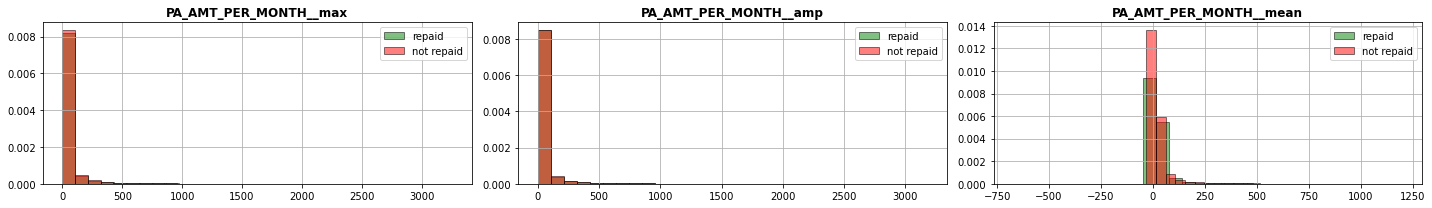

In [56]:
# All quantitative columns in Previous requests to bureau (Home Credit)  (df_3)

cols =  [col for col in df_3.columns if col in (f64_cols + int_cols)]

plot_cat_histograms(df=dict_df['app_train'],
                    ind_tuple=(target_0_df.index, target_1_df.index),
                    cols=cols, labels = ('repaid', 'not repaid'),
                    colors = ('green', 'red'),
                    bins=30, figwidth=20, n_cols=3, tight_layout=True, 
                    skip_outliers=True, thresh=5, sh_tit=20)

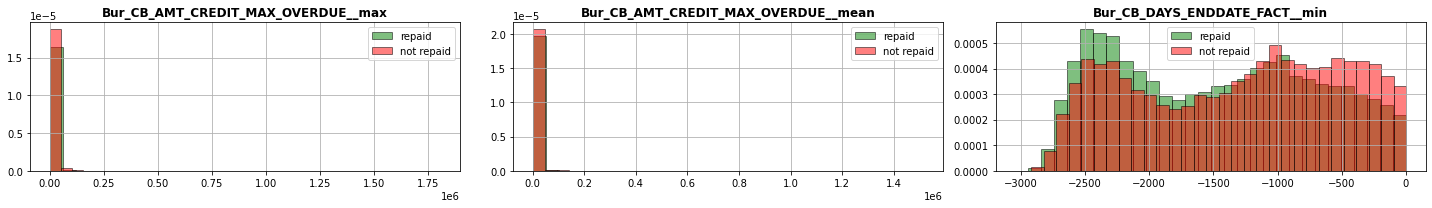

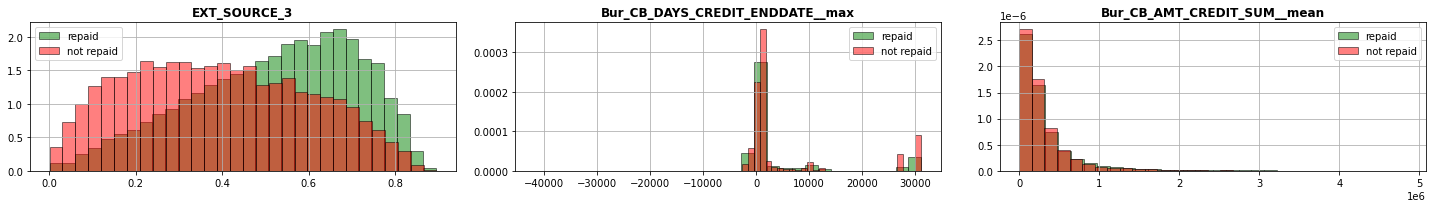

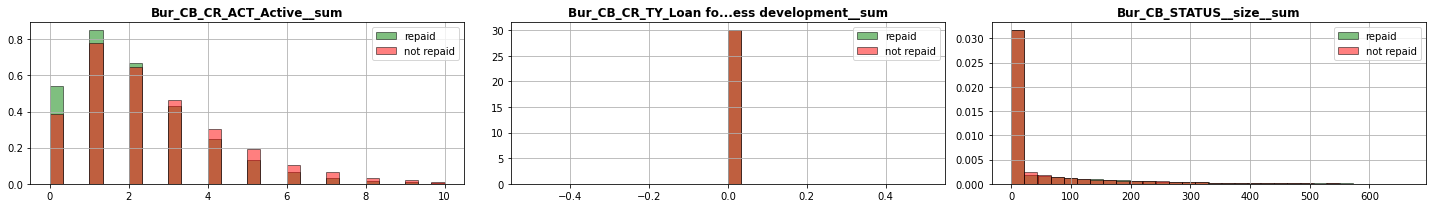

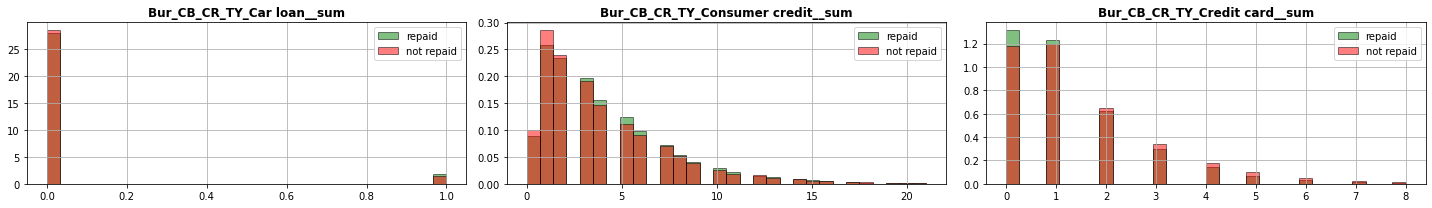

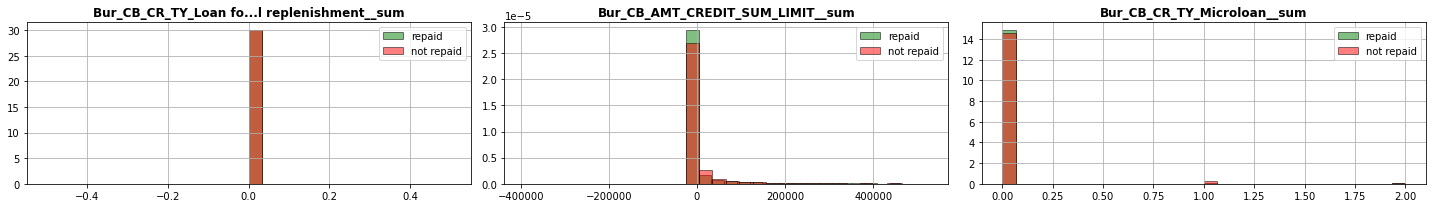

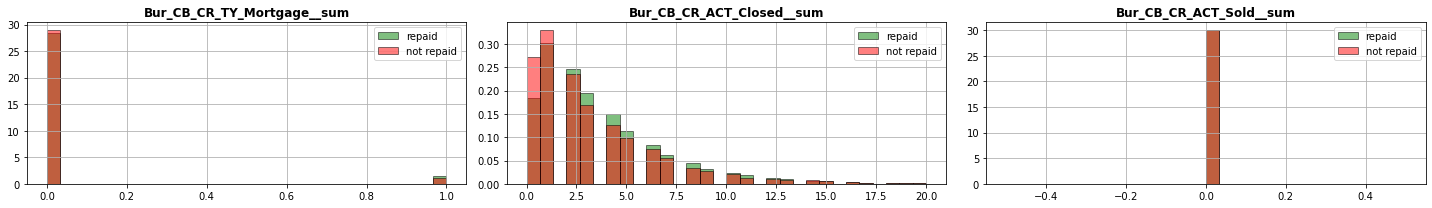

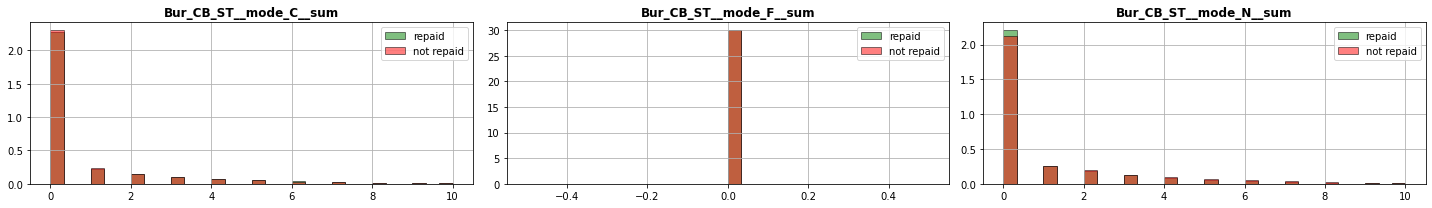

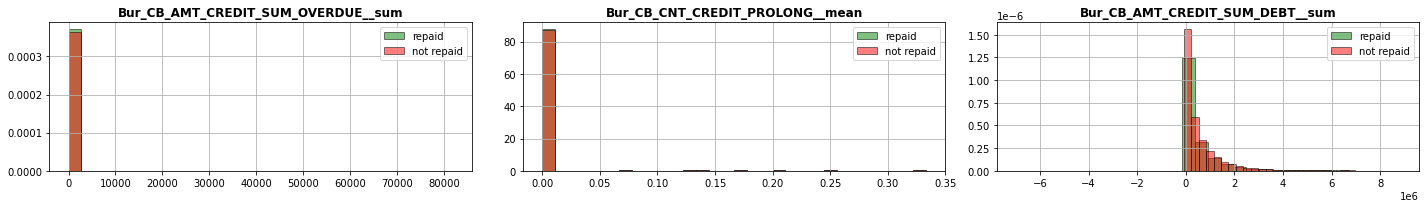

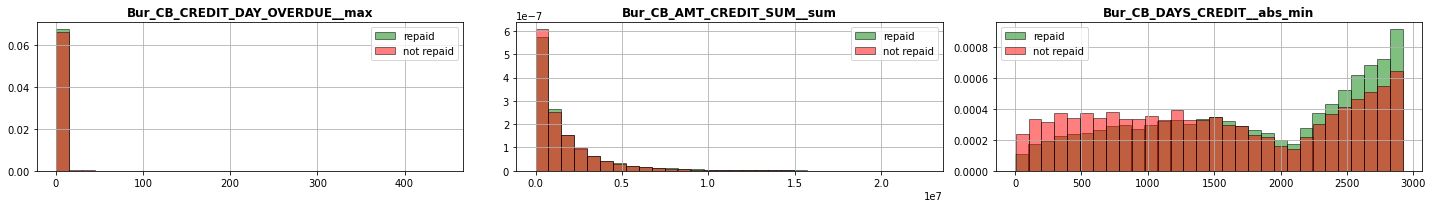

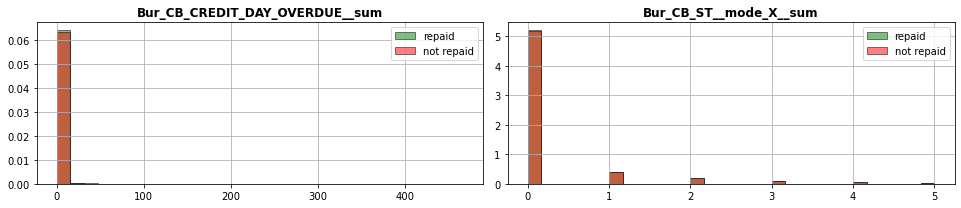

In [57]:
# All quantitative columns in previous applications (Credit Bureau)  (df_4)  

cols =  [col for col in df_4.columns if col in (f64_cols + int_cols)]

plot_cat_histograms(df=dict_df['app_train'],
                    ind_tuple=(target_0_df.index, target_1_df.index),
                    cols=cols, labels = ('repaid', 'not repaid'),
                    colors = ('green', 'red'),
                    bins=30, figwidth=20, n_cols=3, tight_layout=True, 
                    skip_outliers=True, thresh=5, sh_tit=20)

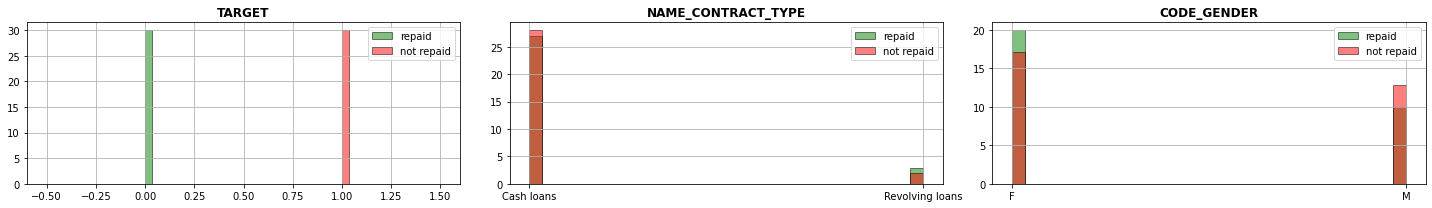

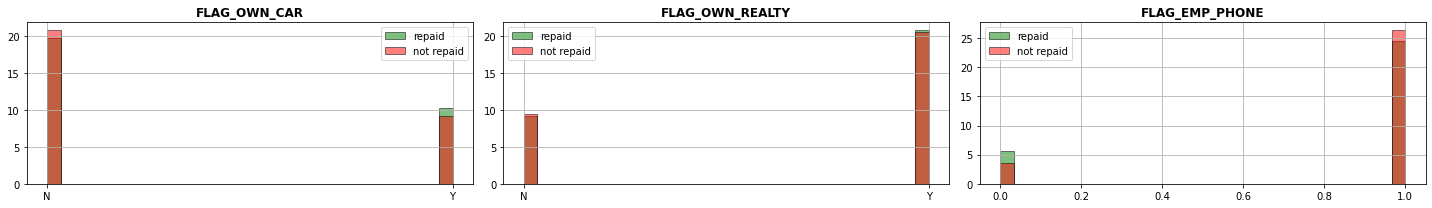

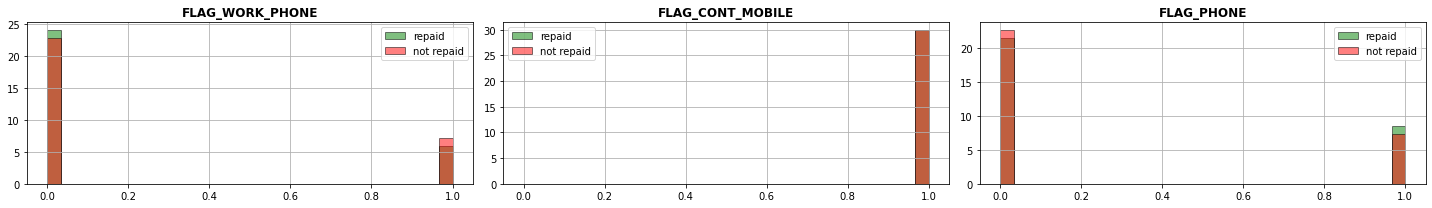

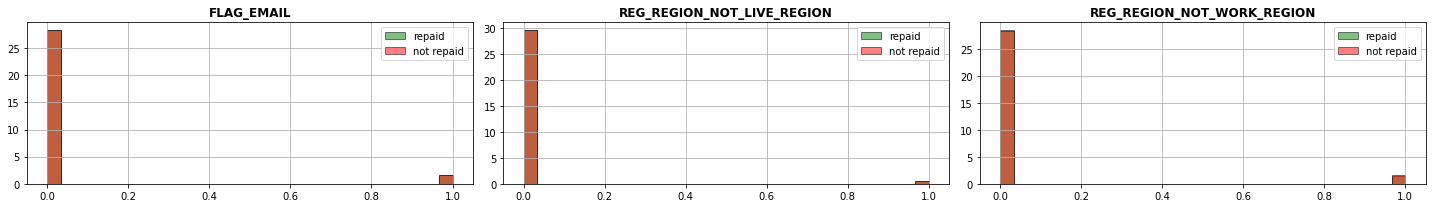

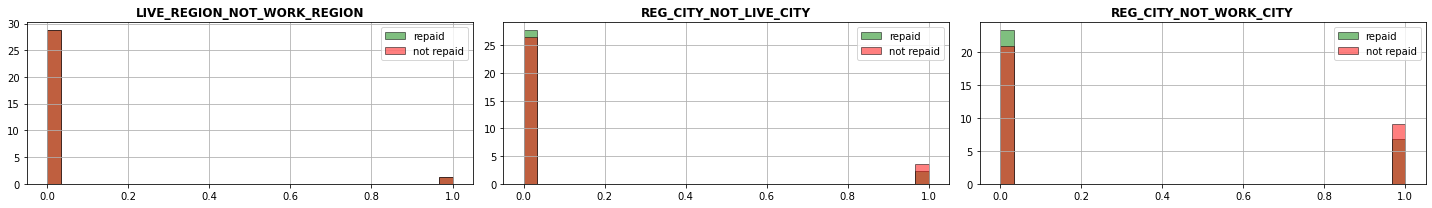

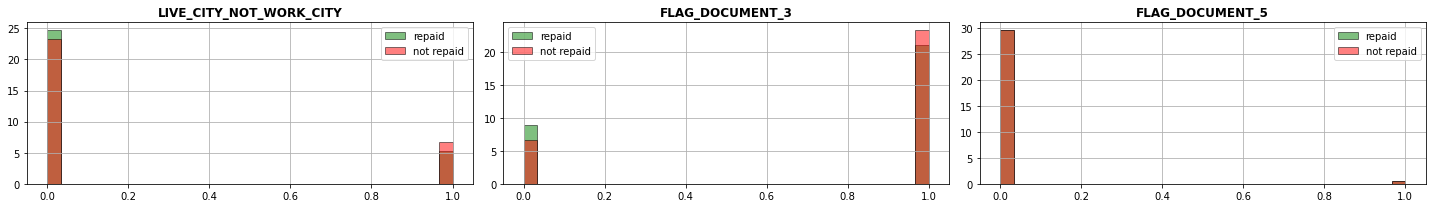

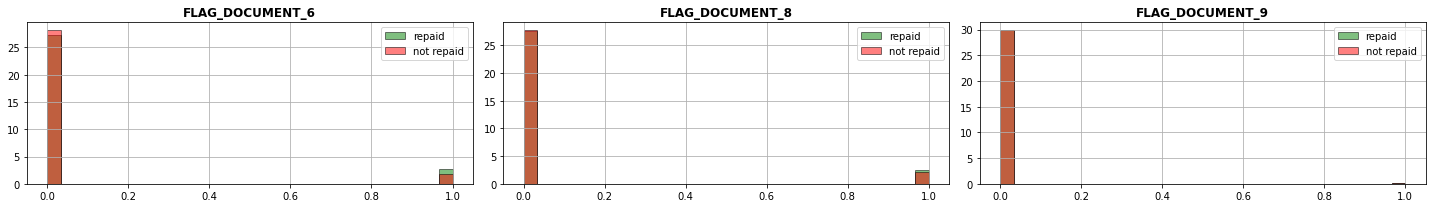

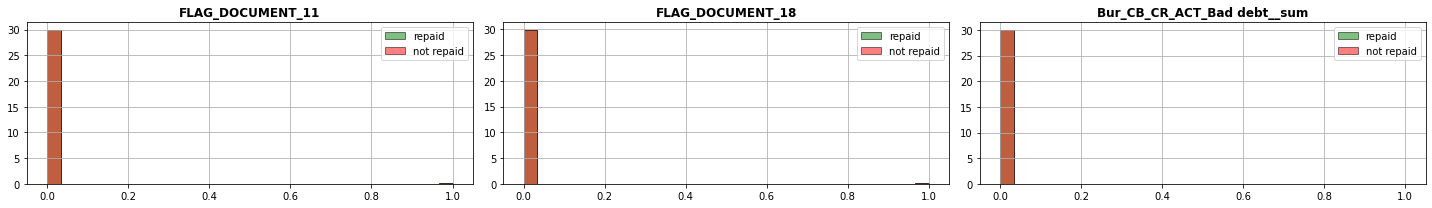

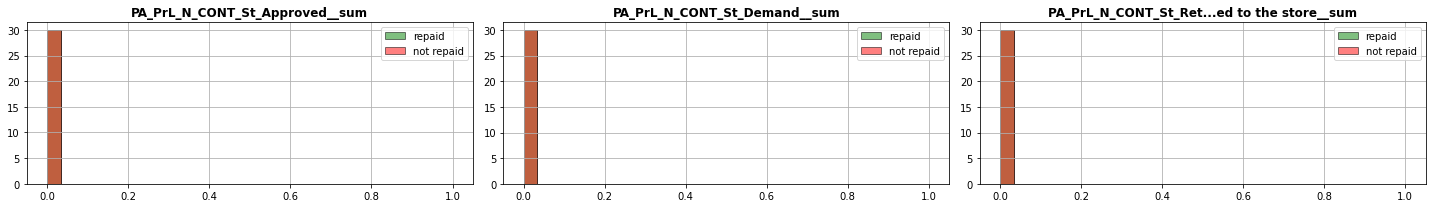

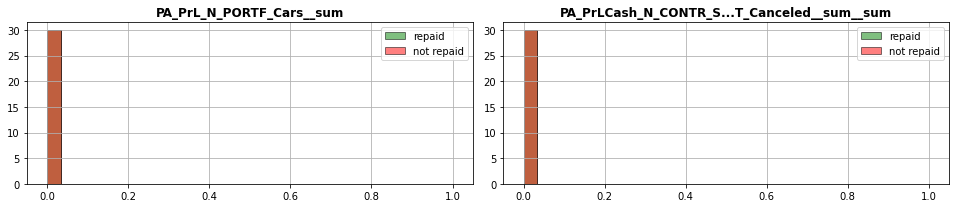

In [58]:
# All binary columns

cols =  bin_cols

plot_cat_histograms(df=dict_df['app_train'],
                    ind_tuple=(target_0_df.index, target_1_df.index),
                    cols=cols, labels = ('repaid', 'not repaid'),
                    colors = ('green', 'red'),
                    bins=2, figwidth=20, n_cols=3, tight_layout=True, 
                    skip_outliers=False, thresh=None,
                    filter_finite=False, sh_tit=20)

In [59]:
few_cat_cols = cat_cols[dict_df['app_train'][cat_cols].nunique()<6]
mid_cat_cols = cat_cols[(dict_df['app_train'][cat_cols].nunique()>=6)&\
                        (dict_df['app_train'][cat_cols].nunique()<10)]
high_cat_cols = cat_cols[dict_df['app_train'][cat_cols].nunique()>10]

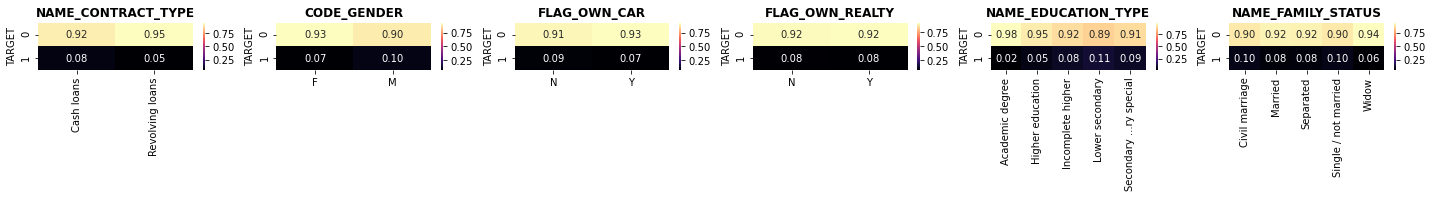

In [60]:
plot_target_ratio_categories(df=dict_df['app_train'], col_target='TARGET',
                             cols=few_cat_cols, figwidth=20, aspect=7,
                             n_cols=6, tight_layout=True, sh_tit=20)

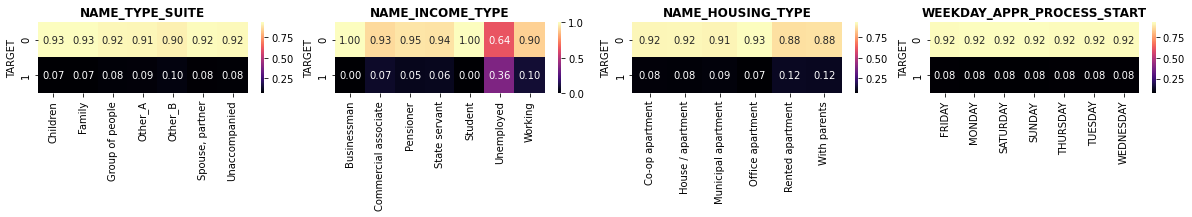

In [61]:
plot_target_ratio_categories(df=dict_df['app_train'], col_target='TARGET',
                             cols=mid_cat_cols, figwidth=25, aspect=8,
                             n_cols=6, tight_layout=True, sh_tit=20)

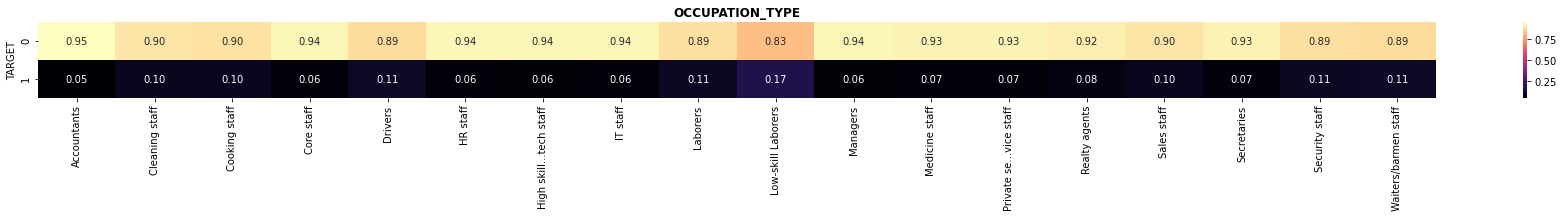

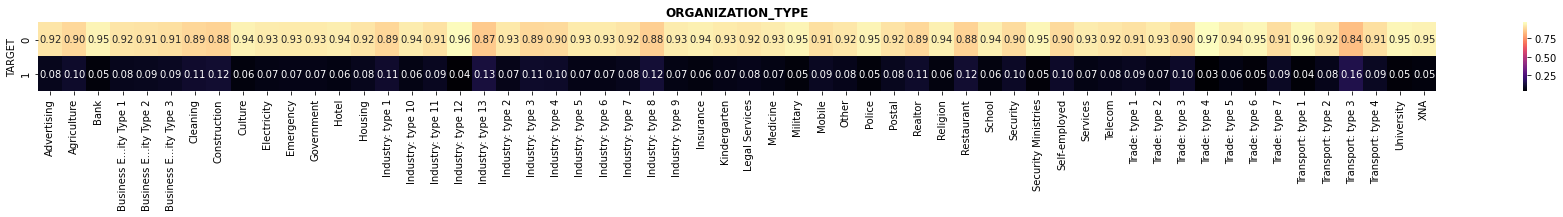

In [62]:
plot_target_ratio_categories(df=dict_df['app_train'], col_target='TARGET',
                             cols=high_cat_cols, figwidth=25, aspect=8,
                             n_cols=1, tight_layout=True, sh_tit=20)

**CONCLUSION :**

**colonnes numériques, non binaires (118)**

- EXT_SOURCE_2/ EXT_SOURCE_3: valeurs sont plus faibles pour les prêts non repayés. Valeur très faible de ce paramètres -> grosse proba d'échec
- DAYS_BIRTH : profil des non payeurs plus jeune
Bur_CB_DAYS_ENDDATE_FACT__min : crédits les plus anciens auraient une légère tendance à être mieux remboursés
- Bur_CB_DAYS_CREDIT__abs_min : mieux repayés lorsque les demandes antérieures sont plus anciennes, moins bien payés (nettement) lorsque les anciennes demandes sont trop récentes.

- (DAYS_EMPLOYED : lègère différence, changement d'emploi récent, plus d'échec
- (DAYS_REGISTRATION : prêts non payés plus fréquents récemment ?)
- (DAYS_LAST_PHONE_CHANGE : légère différence, changement de portable récent, plus d'échec)
- (DAYS_ID_PUBLISH : légère tendance si changement récent d'identité)
- (DAYS_REGISTRATION :  légère tendance si changement récent d'enregistrement)
- (PA_DAYS_FIRST_DUE__min : prêts plus anciens et plus courts plus fréquemment repayés ?
- PA_DAYS_FIRST_DUE__max : pas de différence...)

**colonnes binaires (29)**

- Pas de tendance perceptible

**colonnes catégorielles (12)**

- ORGANIZATION_TYPE, OCCUPATION_TYPE, NAME_EDUCATION_TYPE : légère augmentation de taux d'impayés dans certaines catégories



#### Features - features relationship

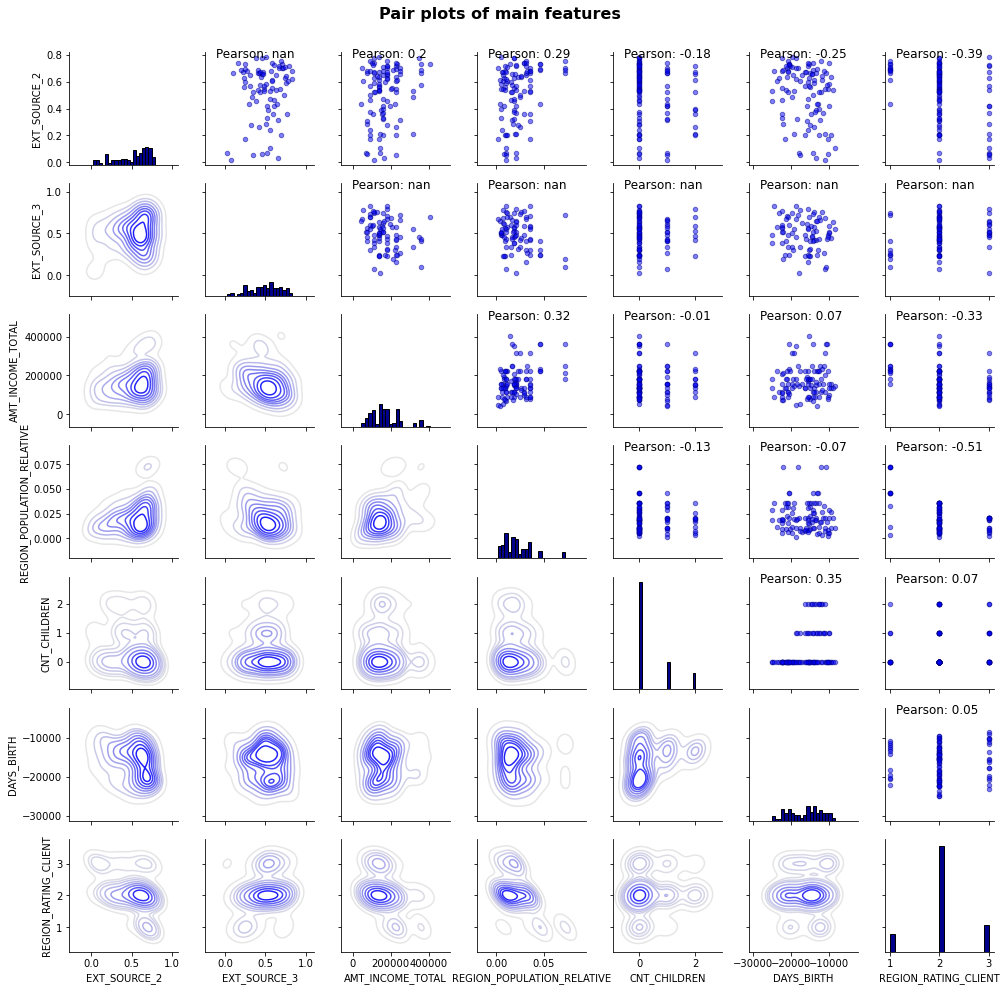

In [63]:
# Scatterplot matrix on main features (too much data -> on a sample)

from matplotlib.colors import ListedColormap

# Creating grey to blue colormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0.9, 0/N, N) # (0.9, 5/N, N)
vals[:, 1] = np.linspace(0.9, 0/N,  N) # (0.9, 80/N,  N)
vals[:, 2] = np.linspace(0.9, 255/N, N) # (0.9, 5/N, N)
Grey2Blue = ListedColormap(vals)

# Function that prints Pearson correlation coefficient
def print_corr(x, y, **kwargs):
    label = r'Pearson: ' + str(round(np.corrcoef(x, y)[0][1], 2))
    ax = plt.gca()
    ax.annotate(label, xy = (0.1, 0.95), c='k', size = 12,
                xycoords = ax.transAxes)

cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE',
 'CNT_CHILDREN', 'DAYS_BIRTH', 'REGION_RATING_CLIENT'] # 'REGION_RATING_CLIENT_W_CITY'
df_sample = dict_df['app_train'].sample(100)

# Creating the grid
grid = sns.PairGrid(data=df_sample,
                    vars=cols, height=2)

# Mapping the grid with plots and text
grid = grid.map_upper(plt.scatter, marker='o', edgecolors='darkblue',
                      alpha=0.5, color='blue', s=20) # , marker='.'

grid = grid.map_upper(print_corr)
grid = grid.map_diag(plt.hist, bins = 20, color = 'darkblue', edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = Grey2Blue)

plt.tight_layout(rect=[0,0,1,0.95])
plt.suptitle('Pair plots of main features',
             fontweight='bold', fontsize=16)

plt.show()

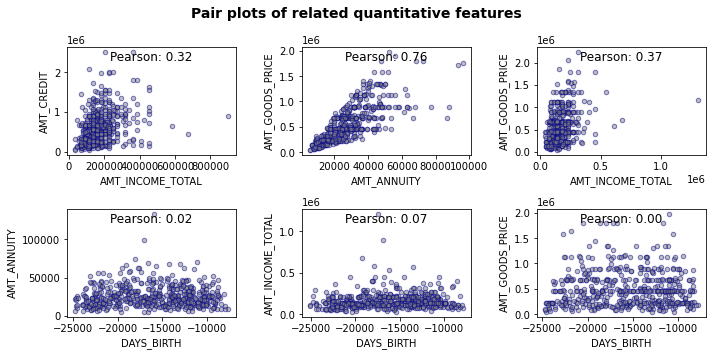

In [64]:
# Function to show scatter plots of chosen features :

def pair_plot(df,c):
    x, y = c
    plt.scatter(df[x], df[y], marker='o', edgecolors='darkblue', # marker='.',
                alpha=0.5, color='grey', s=20)
      
    plt.xlabel(x), plt.ylabel(y)
    plt.text(0.5, 0.9, 'Pearson: %.2f'%df[c].corr().iloc[0,1],
        ha='center', va='center', fontsize=12, c='k', transform=ax.transAxes)

dict_couples = {'c1': ['AMT_INCOME_TOTAL', 'AMT_CREDIT'],
                'c2': ['AMT_ANNUITY', 'AMT_GOODS_PRICE'],
                'c3': ['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE'],
                'c4': ['DAYS_BIRTH', 'AMT_ANNUITY'],
                'c5': ['DAYS_BIRTH', 'AMT_INCOME_TOTAL'],
                'c6': ['DAYS_BIRTH', 'AMT_GOODS_PRICE']}

# Plotting related features

fig = plt.figure(figsize=(10,5))
for i, c in enumerate(dict_couples.items(),1):
    ax = fig.add_subplot(2,3,i)
    pair_plot(dict_df['app_train'].sample(500),c[1])
plt.tight_layout(rect=[0,0,1,0.93])
plt.suptitle('Pair plots of related quantitative features',
             fontweight='bold', fontsize=14)
plt.show()

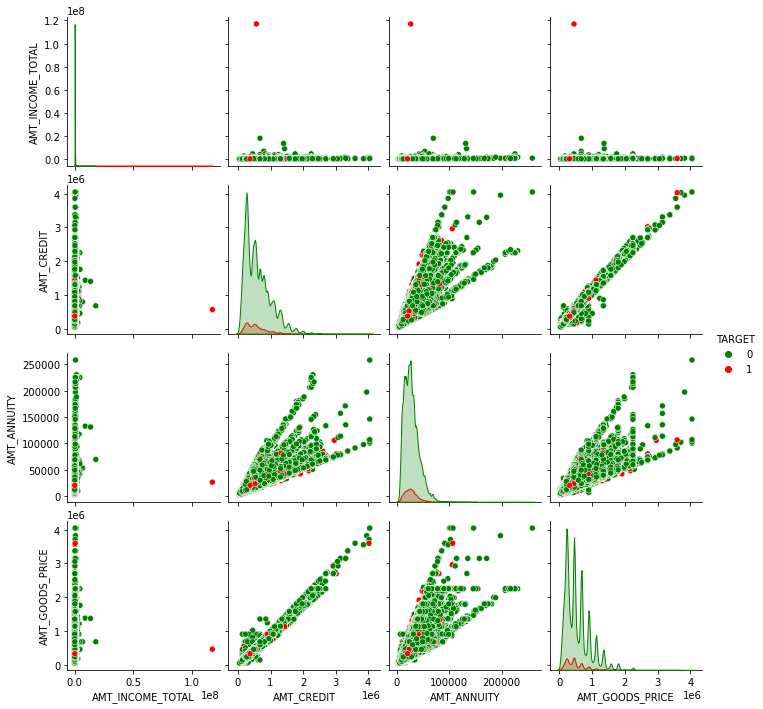

In [65]:
#Let's check the pairplot for amount variables once, to spot any trends

amt = dict_df['app_train'][['AMT_INCOME_TOTAL','AMT_CREDIT',
                         'AMT_ANNUITY', 'AMT_GOODS_PRICE',"TARGET"]]
amt = amt[(amt["AMT_GOODS_PRICE"].notnull()) & (amt["AMT_ANNUITY"].notnull())]
sns.pairplot(amt, hue="TARGET", palette=["g","r"])
plt.show()

Conclusion

A lot of defaulters were concentrated in the low income region .
The annuity amount for the loans issued to these defaulters was also low, yet they defaulted on the payments.

In [66]:
# Plotting heatmap (2 options available, rectangle or triangle )
import seaborn as sns

def plot_heatmap(corr, title, figsize=(8, 4), vmin=-1, vmax=1, center=0,
                 palette=sns.color_palette("coolwarm", 20), shape='rect',
                 annot=True, fmt='.2f', robust=False, fig=None, ax=None):

    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax

    if shape == 'rect':
        mask = None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=annot, annot_kws={"size": 10}, fmt=fmt,
                     square=False, linewidths=.5, linecolor='white',
                     cbar_kws={"shrink": .9, 'label': None}, robust=robust,
                     xticklabels=corr.columns, yticklabels=corr.index,
                     ax=ax)
    ax.tick_params(labelsize=10, top=False, bottom=True,
                   labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)


In [67]:
# Linear correlation (Pearson) among the floats

pears_corr = dict_df['app_train'][f64_cols].corr()

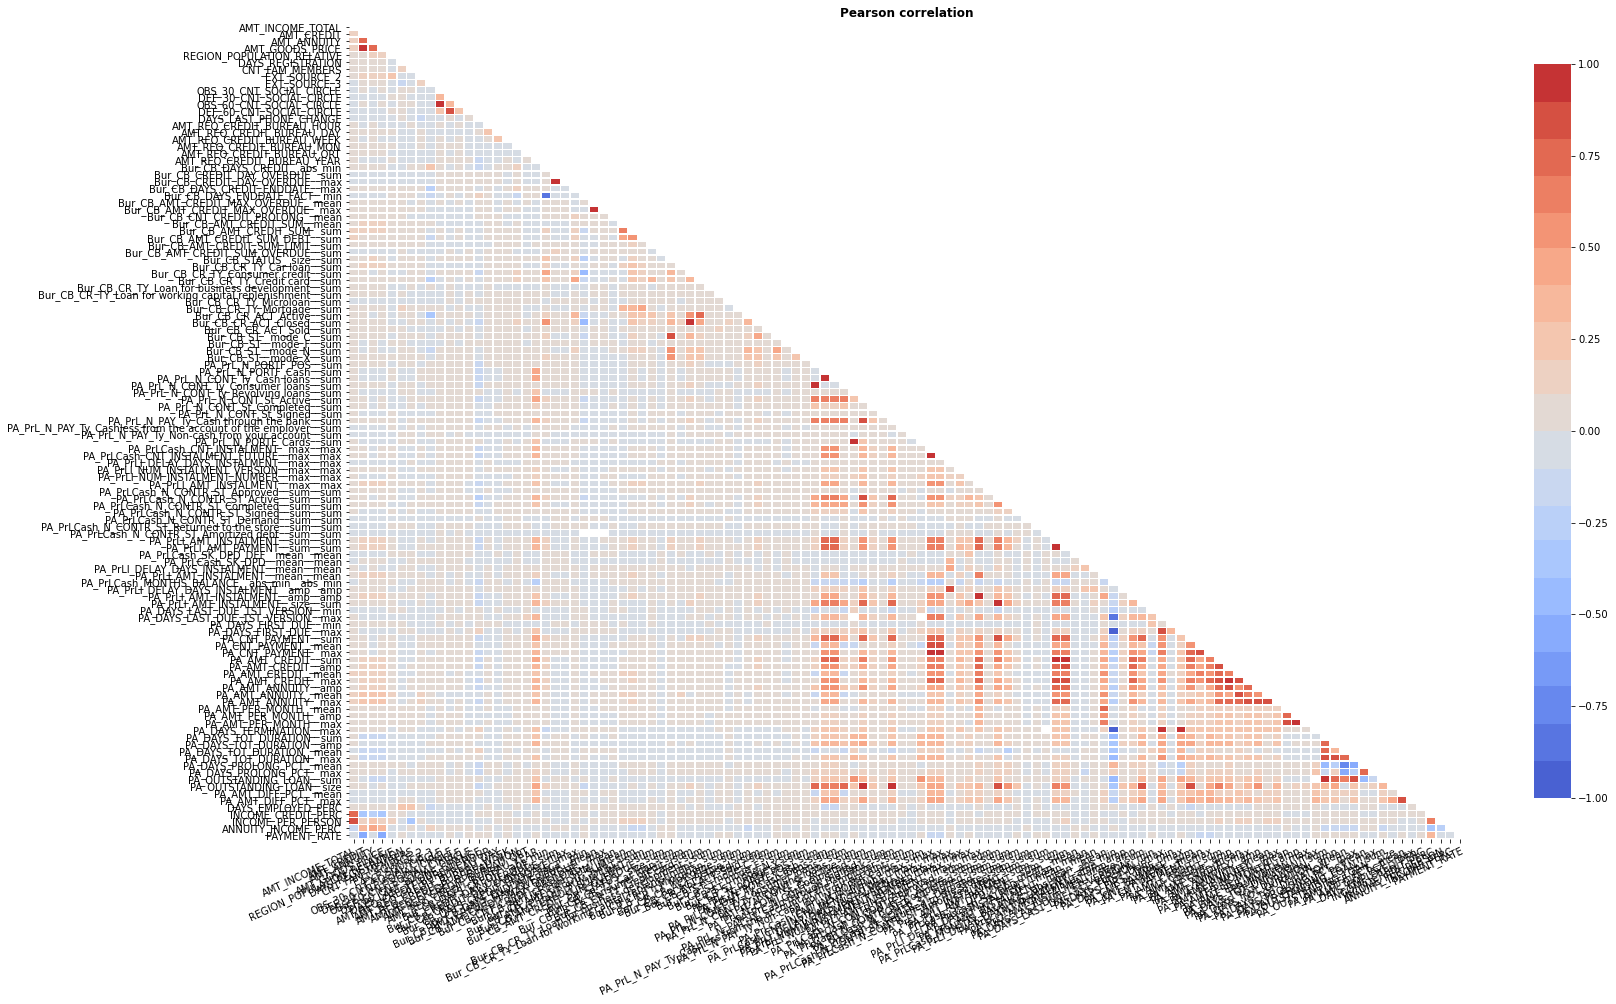

In [68]:
# plot the linear correlation

plot_heatmap(pears_corr, shape='tri', annot=False,
             title="Pearson correlation", figsize=(25,15))
plt.show()

#### Relation of main features with the others

In [69]:
sel_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CNT_CHILDREN', 'DAYS_BIRTH',
 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

Exploring the relation of 'AMT_INCOME_TOTAL' with the other variables

Exploring the relation of 'DAYS_BIRTH' with the other variables

Exploring the relation of 'AMT_CREDIT' with the other variables

In [70]:
cat_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

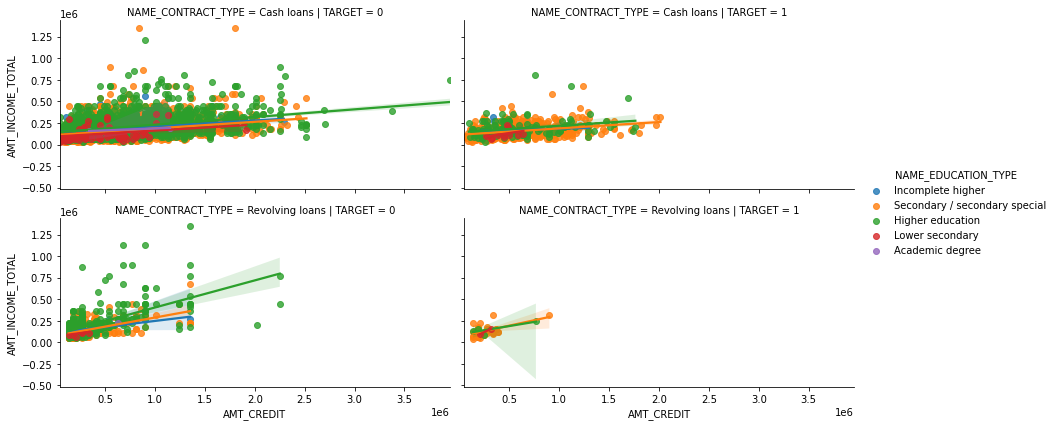

In [71]:
sns.lmplot(data=dict_df['app_train'].sample(10000),
           row='NAME_CONTRACT_TYPE', col='TARGET',
           x='AMT_CREDIT', y='AMT_INCOME_TOTAL', hue='NAME_EDUCATION_TYPE',
           aspect=2, height=3)#, palette=["green", "red"])
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

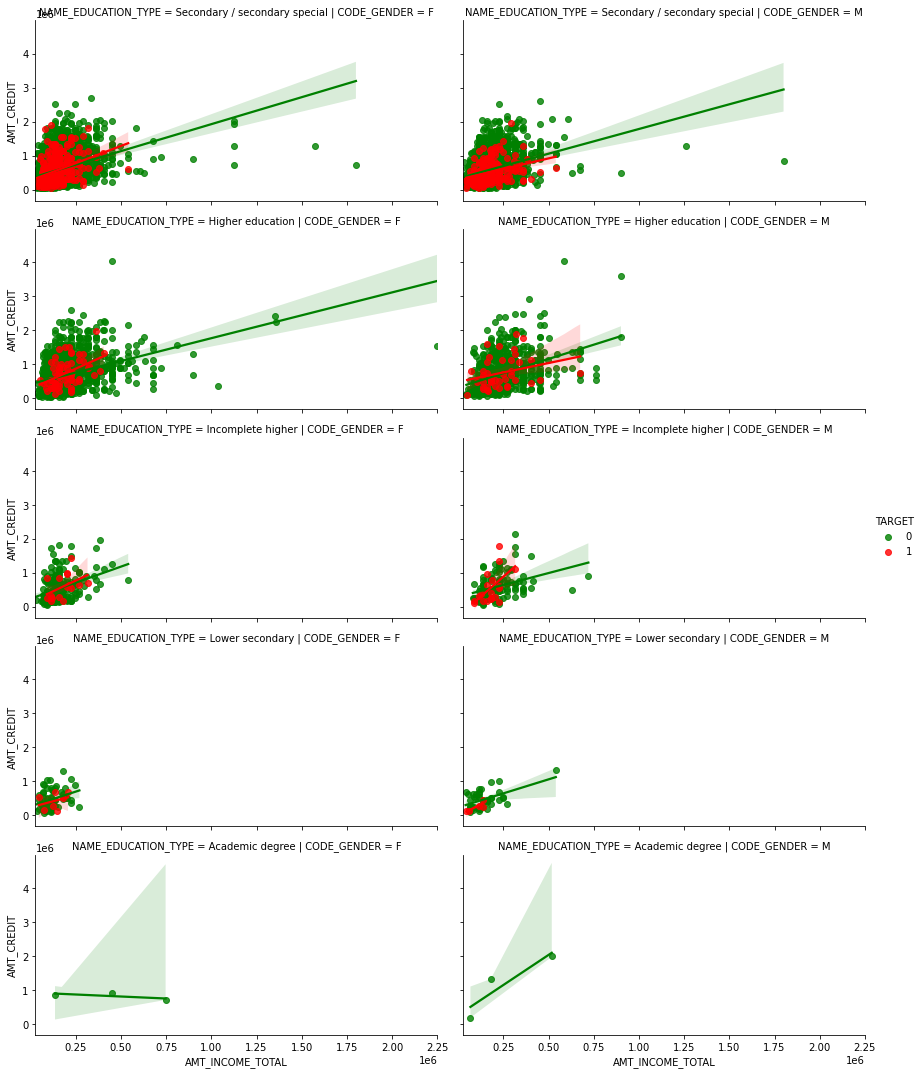

In [72]:
sns.lmplot(data=dict_df['app_train'].sample(10000),
           row='NAME_EDUCATION_TYPE', col='CODE_GENDER',
           x='AMT_INCOME_TOTAL', y='AMT_CREDIT', hue='TARGET',
           aspect=2, height=3, palette=["green", "red"])
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [73]:
cat_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

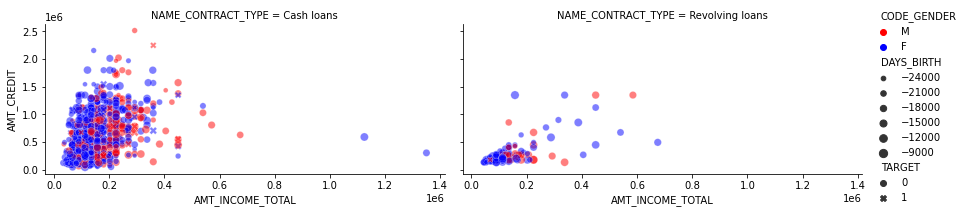

In [74]:
sns.relplot(data=dict_df['app_train'].sample(1000), x='AMT_INCOME_TOTAL', y="AMT_CREDIT",
            hue="CODE_GENDER",  size="DAYS_BIRTH", style='TARGET',
            col="NAME_CONTRACT_TYPE", alpha=0.5, aspect=2, height=3,
            palette=["red", "blue"])

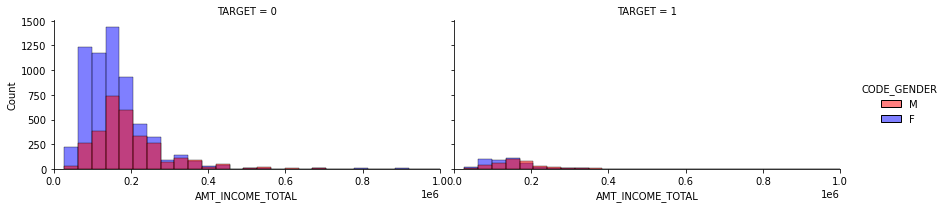

In [75]:
ax = sns.displot(data=dict_df['app_train'].sample(10000), x='AMT_INCOME_TOTAL', 
                 kind='hist', bins=100,# y="AMT_CREDIT", 
                 col='TARGET', col_wrap=2, hue="CODE_GENDER", alpha=0.5, palette=["red", "blue"],
                 aspect=2, height=3)#, edgecolor='k')
ax.set(xlim=(0,1e6))

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='AMT_INCOME_TOTAL'>

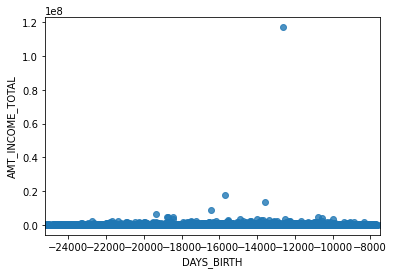

In [76]:
sns.regplot(x="DAYS_BIRTH", y="AMT_INCOME_TOTAL", data=dict_df['app_train'], x_jitter=.1)

In [1]:
import category_encoders as ce

In [ ]:
ce.

In [ ]:
print( )

In [ ]:
# 

In [88]:
speak("youpi c'est fini", 'fr')

### 2.3 Multivariate analysis

In [77]:
import prince

#### Principal Component Analysis (PCA)

In [79]:
pca = prince.PCA(n_components=2, n_iter=3, rescale_with_mean=True,
                 rescale_with_std=True, copy=True, check_input=True,
                 engine='auto', random_state=14)
pca = pca.fit(dict_df['app_train'][quant_cols])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
ax = pca.plot_row_coordinates(
...     X,
...     ax=None,
...     figsize=(6, 6),
...     x_component=0,
...     y_component=1,
...     labels=None,
...     color_labels=y,
...     ellipse_outline=False,
...     ellipse_fill=True,
...     show_points=True
... )

#### Multiple Correspondance Analysis (MCA)

## 3 Exportation

In [ ]:
### Pickling the aggregated dataset

import dill as pickle

with open('dict_df_cleaned.pkl', 'wb') as file:
    pickle.dump(dict_df, file)

In [ ]:
# ### Importation
# import dill as pickle
# with open('dict_df_cleaned.pkl', 'rb') as file:
#     dict_df = pickle.load(file)